In [1]:
from sklearn.preprocessing import LabelBinarizer,MinMaxScaler,LabelEncoder,OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import MobileNetV2
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.layers import concatenate
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import datetime
import pandas as pd
import numpy as np
import argparse
import locale
import glob
import cv2
import os

In [2]:
def preprocesa_atributos(input_path):
    
    HOY = pd.to_datetime(datetime.date(2021,6,30)) # Fecha nominal para calcular los días de cobertura pendiente
    '''
    Dada la ruta a un archivo devuelve partición en conjuntos de entrenamiento y validación
    input: ruta a un archivo, el que debe contener en una el link a la foto.
    output: Conjuntos de entrenamiento y Validación, además de pd.Series con ruta a las imágenes
    '''
    
    df=pd.read_csv(input_path, sep=';')
    df.dropna(inplace=True)
    df = df.drop(columns=['Condition']) # Queremos predecir el monto, por el momento no nos interesa
    df = df[(df['Amount']<=df['Cost_of_vehicle'])] #Filtramos casos: Monto del daño no debiera ser > valor auto
    df = df[df['Amount']>0] #Elimino vehículos sin daño
    
    df['Expiry_date']=pd.to_datetime(df['Expiry_date'])
    df['dias_pendientes_cobertura']=(df['Expiry_date']-HOY).dt.days.astype(int) #Permite contar días hasta fin cobertura
    df['relative_amount'] = df['Amount']/df['Cost_of_vehicle'] #Se expresa en términos relativos
    df['relative_max_cov'] = df['Max_coverage']/df['Cost_of_vehicle'] #Se expresa en términos relativos
    
    
    df = df.drop(columns=['Min_coverage','Expiry_date','Max_coverage','Amount'])
    
    scaler = MinMaxScaler() #Vamos a escalar variables numéricas
     
    X = df.drop(columns=['relative_amount'])
    y = df['relative_amount']
    
    
    #Revisar el test size, de manera que el conjunto de validación tenga un n usual (20%-30%)
    
    X_train,X_val,y_train,y_val = train_test_split(X, y, test_size=0.6)
    
    
    
    X_train_num = X_train[['Cost_of_vehicle','dias_pendientes_cobertura']]
    X_val_num = X_val[['Cost_of_vehicle','dias_pendientes_cobertura']]
    
    X_train_num_scaled = pd.DataFrame(scaler.fit_transform(X_train_num), 
                                      columns=X_train_num.columns,
                                      index=X_train.index)
    
    X_val_num_scaled = pd.DataFrame(scaler.transform(X_val_num), 
                                      columns=X_val_num.columns,
                                       index=X_val.index)
    
    lb = LabelBinarizer()# Codificaremos valores categóricos
    
    
    X_train_encoded = pd.DataFrame(lb.fit_transform(X_train['Insurance_company']),
                                    columns=lb.classes_,
                                   index=X_train.index)
    
    X_val_encoded = pd.DataFrame(lb.transform(X_val['Insurance_company']),
                                    columns=lb.classes_,
                                   index=X_val.index)
    
    
    X_train_feat = pd.concat([X_train['relative_max_cov'],X_train_num_scaled,X_train_encoded],axis=1)
    X_val_feat = pd.concat([X_val['relative_max_cov'],X_val_num_scaled,X_val_encoded],axis=1)
    
    X_train_im = X_train['Image_path']
    X_val_im = X_val['Image_path']
    
    
    return X_train_feat,X_train_im, X_val_feat,X_val_im,y_train,y_val

In [3]:
#X_train_feat,X_train_im, X_val_feat,X_val_im,y_train,y_val = preprocesa_atributos('train_original2.csv')

In [4]:
#len(X_train_feat)

In [5]:
#len(X_val_feat)

In [6]:
662/(5*541+662)

0.1966141966141966

In [7]:
def carga_imagenes(serie_fotos, inputPath):
    
    nuevas_imagenes = []
    for foto in serie_fotos:
        imagen = cv2.imread(inputPath+'/'+foto)
        imagen = cv2.resize(imagen, (64, 64)) #Dejo todas las fotos en 64 x 64
        nuevas_imagenes.append(imagen)
    return np.array(nuevas_imagenes)/255.0 # Normalizo a factor de 1

In [8]:
def create_mlp(dim, regress=True):
    # Perceptron multicapas muy simple para Redes neuronales
    model = Sequential()
    model.add(Dense(8, input_dim=dim, activation="relu"))
    model.add(Dense(1, activation="relu"))

    # ¿Hay nodo de regresión?
    if regress:
        model.add(Dense(1, activation="linear"))

    # Devuelve un modelo
    return model

In [9]:
def create_cnn(width, height, depth, filters=(16, 32, 64), regress=True):
# Ojo: hay que cambiar orden de las dimensiones

    inputShape = (height, width, depth)
    chanDim = -1

    # Definir input del modelos
    inputs = Input(shape=inputShape)

    # Loop para cada uno de los filtros
    for (i, f) in enumerate(filters):
    # Ojo con capas de convolución
        if i == 0:
            x = inputs

    # CONV => RELU => BN => POOL
    x = Conv2D(f, (3, 3), padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Aplanar nuevamente, luego FC => RELU => BN => DROPOUT
    x = Flatten()(x)
    x = Dense(32)(x)
    x = Dense(8)(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = Dropout(0.5)(x)

    # Aplicar al final
    x = Dense(1)(x)
    x = Activation("relu")(x)

    # ¿Hay nodo de regresión?
    if regress:
        x = Dense(1, activation="linear")(x)

    # construct the CNN
    model = Model(inputs, x)

    # return the CNN
    return model

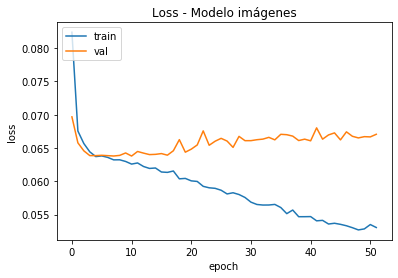

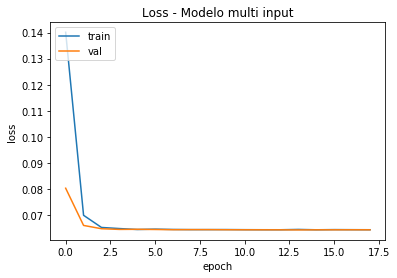

El promedio de y en el conjunto de entrenamiento es 0.1226, y contiene 2886 casos
El promedio de y en el conjunto de validación es 0.1261, y contiene 722 casos
El error absoluto promedio del modelo que solo usa imágenes es 0.0671
A su vez, el error absoluto promedio en el modelo multi-input es 0.0643.
Iteración 1 finalizada


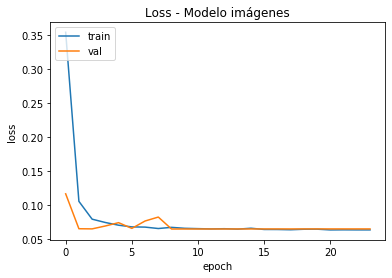

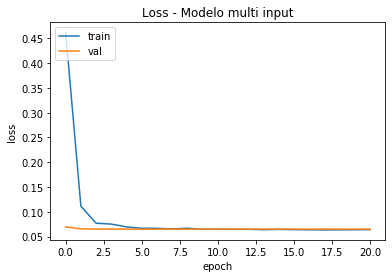

El promedio de y en el conjunto de entrenamiento es 0.1229, y contiene 2886 casos
El promedio de y en el conjunto de validación es 0.1259, y contiene 722 casos
El error absoluto promedio del modelo que solo usa imágenes es 0.0652
A su vez, el error absoluto promedio en el modelo multi-input es 0.0652.
Iteración 2 finalizada


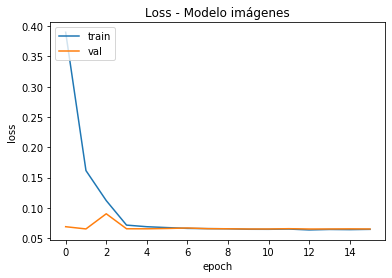

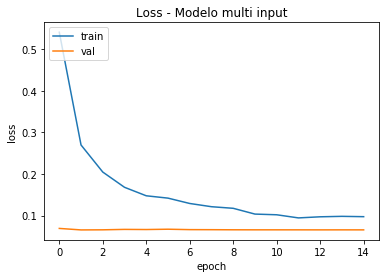

El promedio de y en el conjunto de entrenamiento es 0.1268, y contiene 2886 casos
El promedio de y en el conjunto de validación es 0.1233, y contiene 722 casos
El error absoluto promedio del modelo que solo usa imágenes es 0.0654
A su vez, el error absoluto promedio en el modelo multi-input es 0.0655.
Iteración 3 finalizada


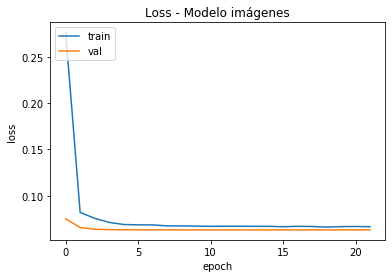

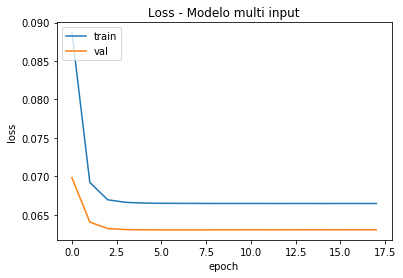

El promedio de y en el conjunto de entrenamiento es 0.1258, y contiene 2886 casos
El promedio de y en el conjunto de validación es 0.1239, y contiene 722 casos
El error absoluto promedio del modelo que solo usa imágenes es 0.0631
A su vez, el error absoluto promedio en el modelo multi-input es 0.0631.
Iteración 4 finalizada


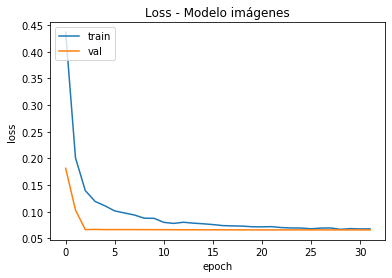

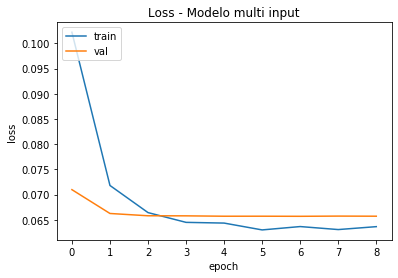

El promedio de y en el conjunto de entrenamiento es 0.1252, y contiene 2886 casos
El promedio de y en el conjunto de validación es 0.1244, y contiene 722 casos
El error absoluto promedio del modelo que solo usa imágenes es 0.0658
A su vez, el error absoluto promedio en el modelo multi-input es 0.0657.
Iteración 5 finalizada


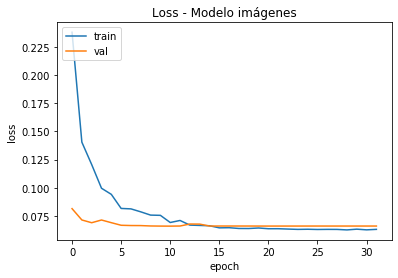

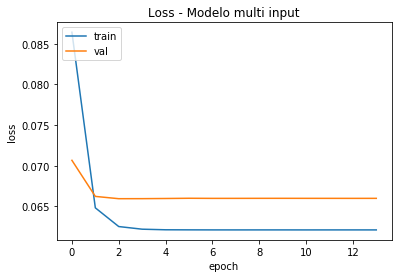

El promedio de y en el conjunto de entrenamiento es 0.126, y contiene 2886 casos
El promedio de y en el conjunto de validación es 0.1238, y contiene 722 casos
El error absoluto promedio del modelo que solo usa imágenes es 0.066
A su vez, el error absoluto promedio en el modelo multi-input es 0.066.
Iteración 6 finalizada


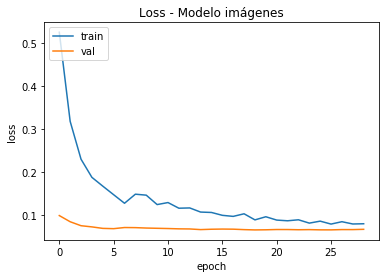

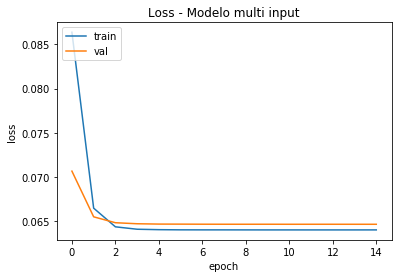

El promedio de y en el conjunto de entrenamiento es 0.123, y contiene 2886 casos
El promedio de y en el conjunto de validación es 0.1258, y contiene 722 casos
El error absoluto promedio del modelo que solo usa imágenes es 0.0671
A su vez, el error absoluto promedio en el modelo multi-input es 0.0647.
Iteración 7 finalizada


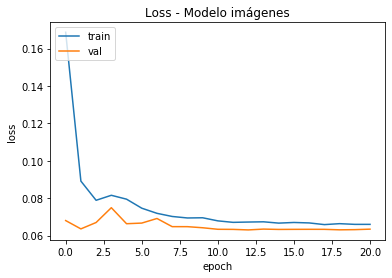

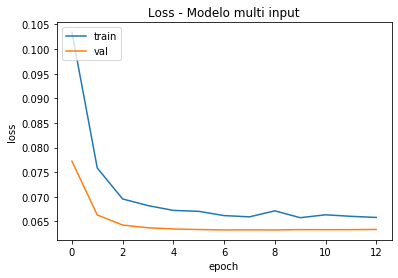

El promedio de y en el conjunto de entrenamiento es 0.125, y contiene 2886 casos
El promedio de y en el conjunto de validación es 0.1245, y contiene 722 casos
El error absoluto promedio del modelo que solo usa imágenes es 0.0635
A su vez, el error absoluto promedio en el modelo multi-input es 0.0634.
Iteración 8 finalizada


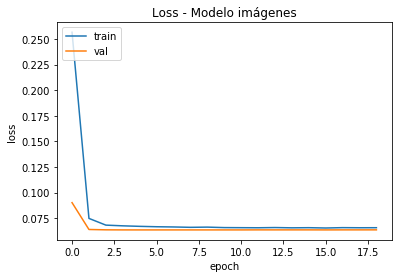

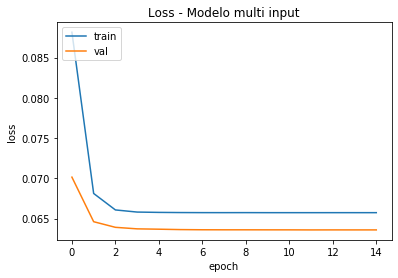

El promedio de y en el conjunto de entrenamiento es 0.1258, y contiene 2886 casos
El promedio de y en el conjunto de validación es 0.1239, y contiene 722 casos
El error absoluto promedio del modelo que solo usa imágenes es 0.0636
A su vez, el error absoluto promedio en el modelo multi-input es 0.0636.
Iteración 9 finalizada


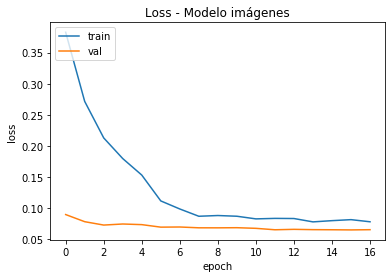

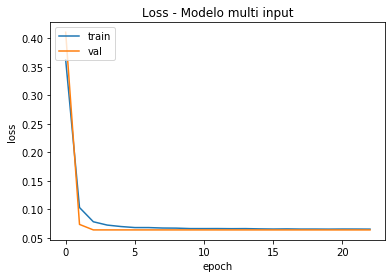

El promedio de y en el conjunto de entrenamiento es 0.126, y contiene 2886 casos
El promedio de y en el conjunto de validación es 0.1238, y contiene 722 casos
El error absoluto promedio del modelo que solo usa imágenes es 0.065
A su vez, el error absoluto promedio en el modelo multi-input es 0.0639.
Iteración 10 finalizada


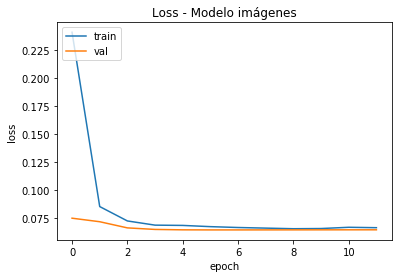

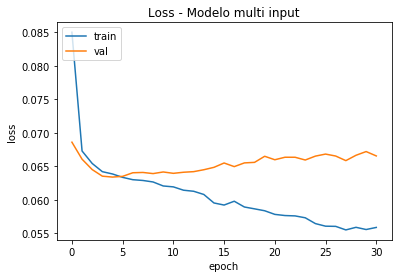

El promedio de y en el conjunto de entrenamiento es 0.1282, y contiene 2886 casos
El promedio de y en el conjunto de validación es 0.1224, y contiene 722 casos
El error absoluto promedio del modelo que solo usa imágenes es 0.0642
A su vez, el error absoluto promedio en el modelo multi-input es 0.0666.
Iteración 11 finalizada


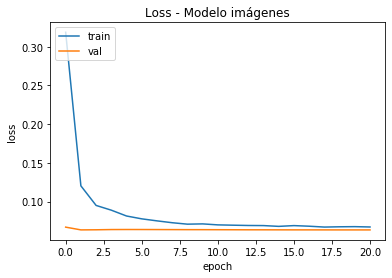

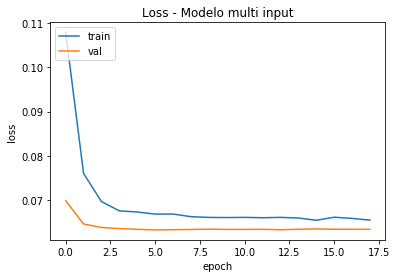

El promedio de y en el conjunto de entrenamiento es 0.1266, y contiene 2886 casos
El promedio de y en el conjunto de validación es 0.1234, y contiene 722 casos
El error absoluto promedio del modelo que solo usa imágenes es 0.0634
A su vez, el error absoluto promedio en el modelo multi-input es 0.0634.
Iteración 12 finalizada


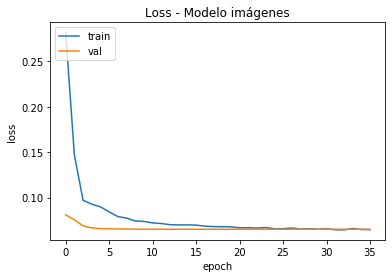

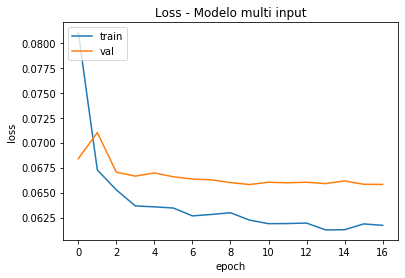

El promedio de y en el conjunto de entrenamiento es 0.1248, y contiene 2886 casos
El promedio de y en el conjunto de validación es 0.1246, y contiene 722 casos
El error absoluto promedio del modelo que solo usa imágenes es 0.0652
A su vez, el error absoluto promedio en el modelo multi-input es 0.0658.
Iteración 13 finalizada


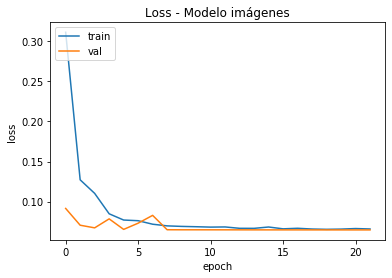

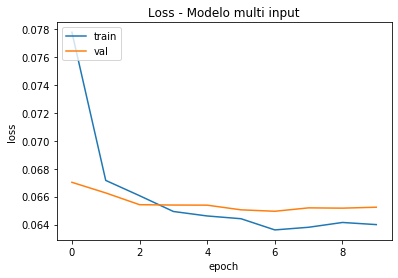

El promedio de y en el conjunto de entrenamiento es 0.1239, y contiene 2886 casos
El promedio de y en el conjunto de validación es 0.1252, y contiene 722 casos
El error absoluto promedio del modelo que solo usa imágenes es 0.0646
A su vez, el error absoluto promedio en el modelo multi-input es 0.0652.
Iteración 14 finalizada


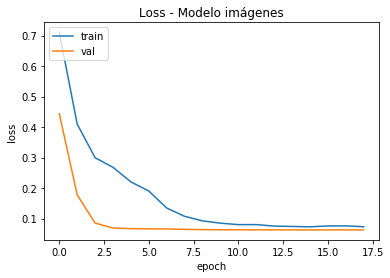

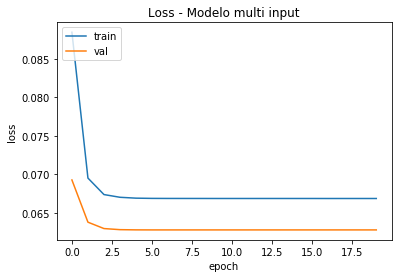

El promedio de y en el conjunto de entrenamiento es 0.125, y contiene 2886 casos
El promedio de y en el conjunto de validación es 0.1244, y contiene 722 casos
El error absoluto promedio del modelo que solo usa imágenes es 0.0629
A su vez, el error absoluto promedio en el modelo multi-input es 0.0628.
Iteración 15 finalizada


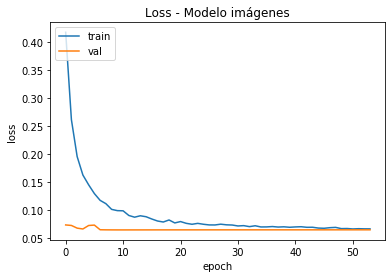

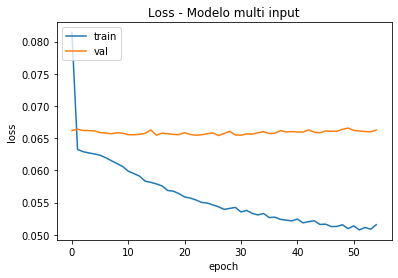

El promedio de y en el conjunto de entrenamiento es 0.1277, y contiene 2886 casos
El promedio de y en el conjunto de validación es 0.1227, y contiene 722 casos
El error absoluto promedio del modelo que solo usa imágenes es 0.0652
A su vez, el error absoluto promedio en el modelo multi-input es 0.0663.
Iteración 16 finalizada


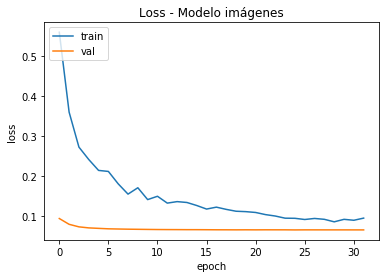

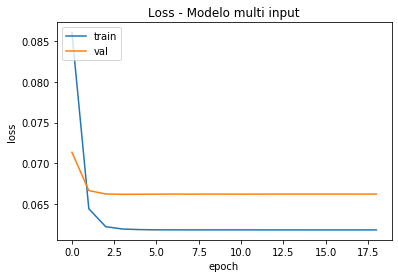

El promedio de y en el conjunto de entrenamiento es 0.1247, y contiene 2886 casos
El promedio de y en el conjunto de validación es 0.1246, y contiene 722 casos
El error absoluto promedio del modelo que solo usa imágenes es 0.0664
A su vez, el error absoluto promedio en el modelo multi-input es 0.0662.
Iteración 17 finalizada


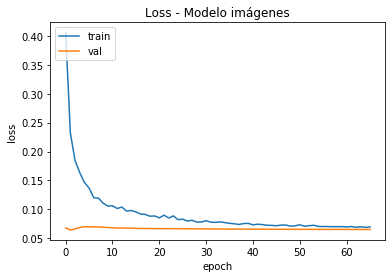

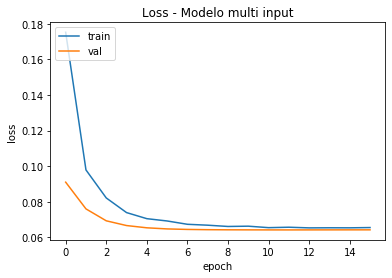

El promedio de y en el conjunto de entrenamiento es 0.1249, y contiene 2886 casos
El promedio de y en el conjunto de validación es 0.1245, y contiene 722 casos
El error absoluto promedio del modelo que solo usa imágenes es 0.0651
A su vez, el error absoluto promedio en el modelo multi-input es 0.0642.
Iteración 18 finalizada


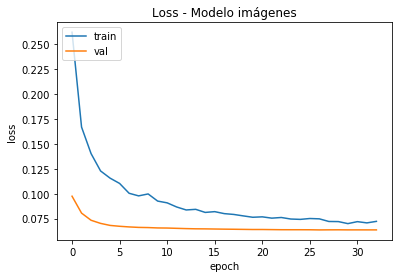

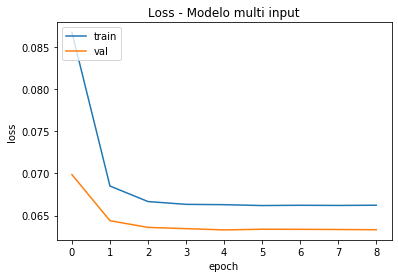

El promedio de y en el conjunto de entrenamiento es 0.1239, y contiene 2886 casos
El promedio de y en el conjunto de validación es 0.1252, y contiene 722 casos
El error absoluto promedio del modelo que solo usa imágenes es 0.0636
A su vez, el error absoluto promedio en el modelo multi-input es 0.0633.
Iteración 19 finalizada


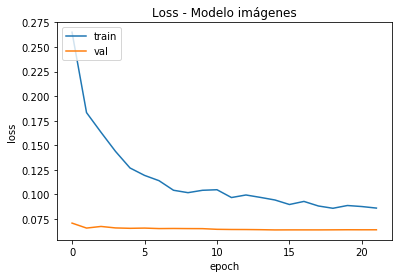

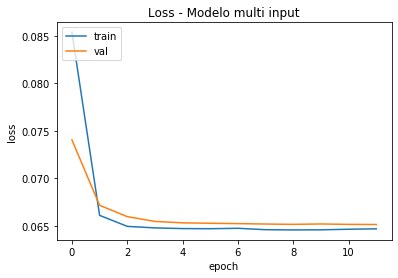

El promedio de y en el conjunto de entrenamiento es 0.1155, y contiene 2886 casos
El promedio de y en el conjunto de validación es 0.1308, y contiene 722 casos
El error absoluto promedio del modelo que solo usa imágenes es 0.0639
A su vez, el error absoluto promedio en el modelo multi-input es 0.0652.
Iteración 20 finalizada


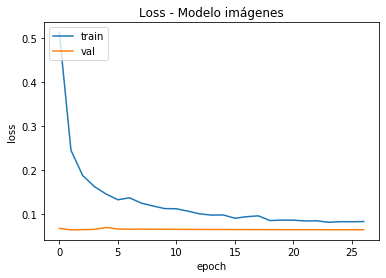

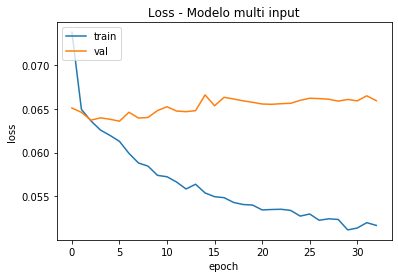

El promedio de y en el conjunto de entrenamiento es 0.1269, y contiene 2886 casos
El promedio de y en el conjunto de validación es 0.1232, y contiene 722 casos
El error absoluto promedio del modelo que solo usa imágenes es 0.0643
A su vez, el error absoluto promedio en el modelo multi-input es 0.0659.
Iteración 21 finalizada


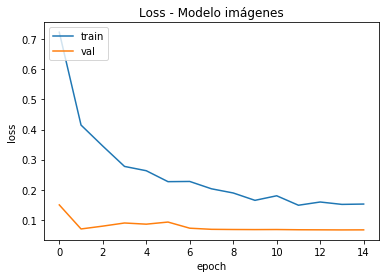

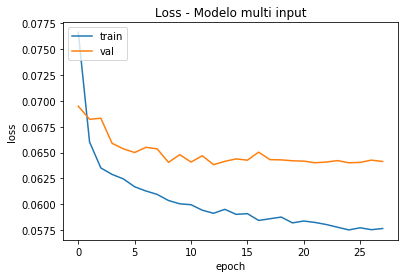

El promedio de y en el conjunto de entrenamiento es 0.1229, y contiene 2886 casos
El promedio de y en el conjunto de validación es 0.1259, y contiene 722 casos
El error absoluto promedio del modelo que solo usa imágenes es 0.0668
A su vez, el error absoluto promedio en el modelo multi-input es 0.0641.
Iteración 22 finalizada


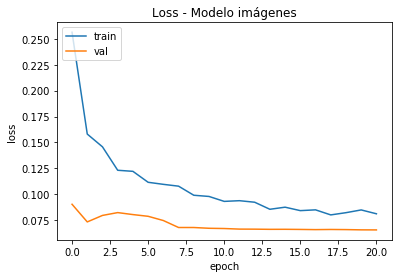

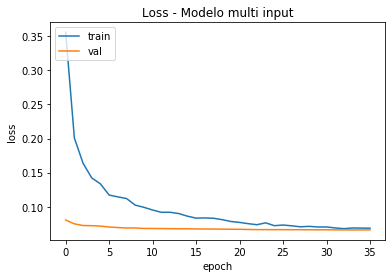

El promedio de y en el conjunto de entrenamiento es 0.1215, y contiene 2886 casos
El promedio de y en el conjunto de validación es 0.1268, y contiene 722 casos
El error absoluto promedio del modelo que solo usa imágenes es 0.0657
A su vez, el error absoluto promedio en el modelo multi-input es 0.0659.
Iteración 23 finalizada


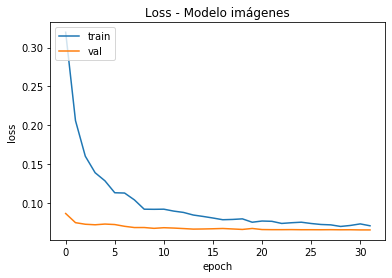

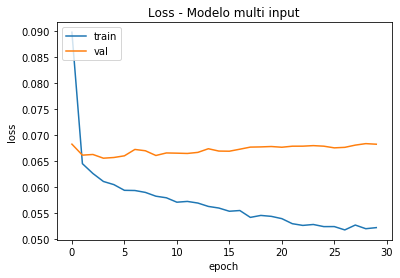

El promedio de y en el conjunto de entrenamiento es 0.1255, y contiene 2886 casos
El promedio de y en el conjunto de validación es 0.1241, y contiene 722 casos
El error absoluto promedio del modelo que solo usa imágenes es 0.0654
A su vez, el error absoluto promedio en el modelo multi-input es 0.0683.
Iteración 24 finalizada


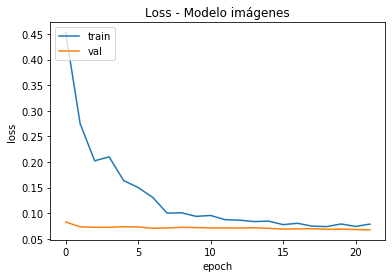

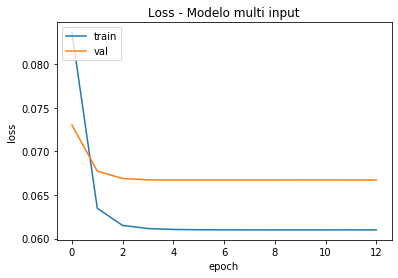

El promedio de y en el conjunto de entrenamiento es 0.1217, y contiene 2886 casos
El promedio de y en el conjunto de validación es 0.1266, y contiene 722 casos
El error absoluto promedio del modelo que solo usa imágenes es 0.0672
A su vez, el error absoluto promedio en el modelo multi-input es 0.0667.
Iteración 25 finalizada


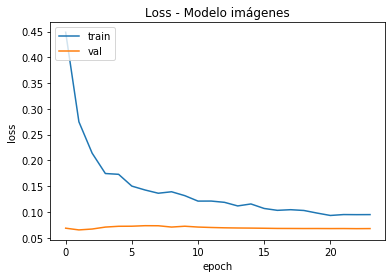

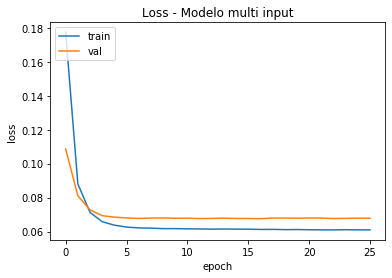

El promedio de y en el conjunto de entrenamiento es 0.1231, y contiene 2886 casos
El promedio de y en el conjunto de validación es 0.1257, y contiene 722 casos
El error absoluto promedio del modelo que solo usa imágenes es 0.0678
A su vez, el error absoluto promedio en el modelo multi-input es 0.0679.
Iteración 26 finalizada


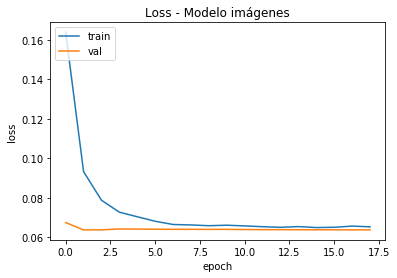

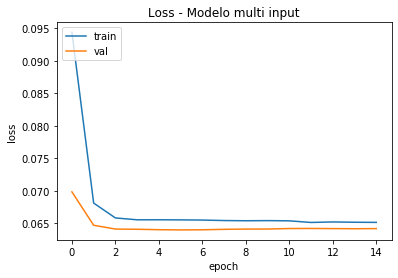

El promedio de y en el conjunto de entrenamiento es 0.1269, y contiene 2886 casos
El promedio de y en el conjunto de validación es 0.1232, y contiene 722 casos
El error absoluto promedio del modelo que solo usa imágenes es 0.0637
A su vez, el error absoluto promedio en el modelo multi-input es 0.0642.
Iteración 27 finalizada


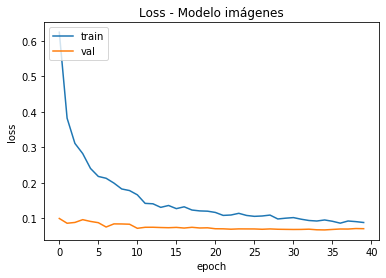

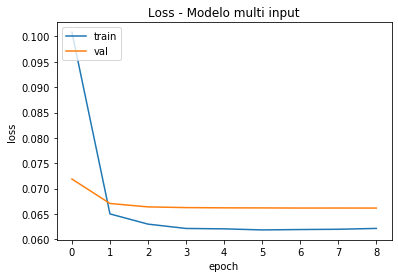

El promedio de y en el conjunto de entrenamiento es 0.1208, y contiene 2886 casos
El promedio de y en el conjunto de validación es 0.1273, y contiene 722 casos
El error absoluto promedio del modelo que solo usa imágenes es 0.0705
A su vez, el error absoluto promedio en el modelo multi-input es 0.0662.
Iteración 28 finalizada


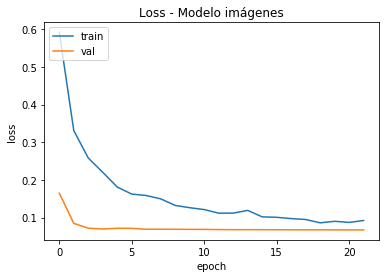

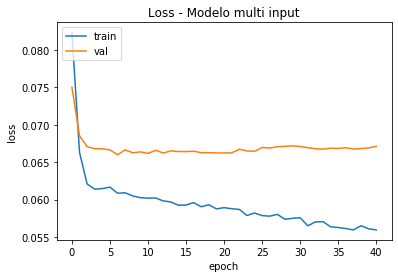

El promedio de y en el conjunto de entrenamiento es 0.1226, y contiene 2886 casos
El promedio de y en el conjunto de validación es 0.126, y contiene 722 casos
El error absoluto promedio del modelo que solo usa imágenes es 0.0671
A su vez, el error absoluto promedio en el modelo multi-input es 0.0671.
Iteración 29 finalizada


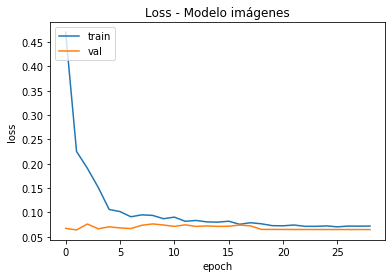

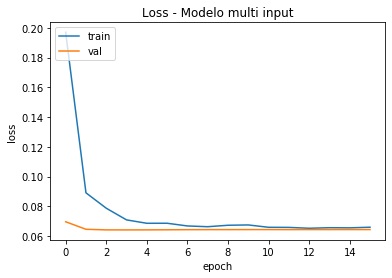

El promedio de y en el conjunto de entrenamiento es 0.1284, y contiene 2886 casos
El promedio de y en el conjunto de validación es 0.1222, y contiene 722 casos
El error absoluto promedio del modelo que solo usa imágenes es 0.065
A su vez, el error absoluto promedio en el modelo multi-input es 0.0644.
Iteración 30 finalizada


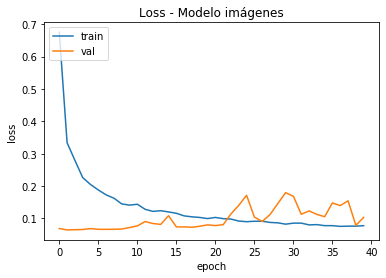

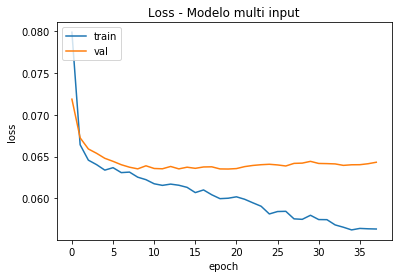

El promedio de y en el conjunto de entrenamiento es 0.1235, y contiene 2886 casos
El promedio de y en el conjunto de validación es 0.1254, y contiene 722 casos
El error absoluto promedio del modelo que solo usa imágenes es 0.1034
A su vez, el error absoluto promedio en el modelo multi-input es 0.0643.
Iteración 31 finalizada


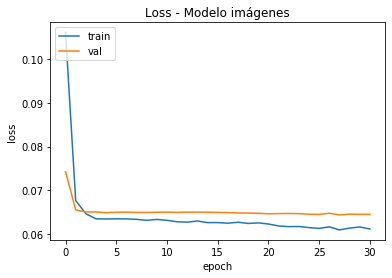

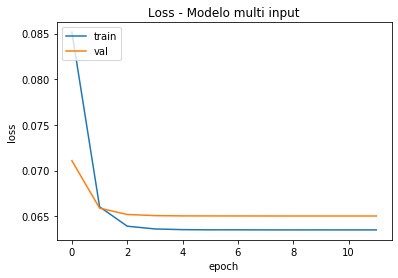

El promedio de y en el conjunto de entrenamiento es 0.1223, y contiene 2886 casos
El promedio de y en el conjunto de validación es 0.1263, y contiene 722 casos
El error absoluto promedio del modelo que solo usa imágenes es 0.0645
A su vez, el error absoluto promedio en el modelo multi-input es 0.065.
Iteración 32 finalizada


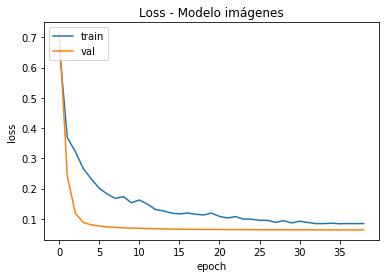

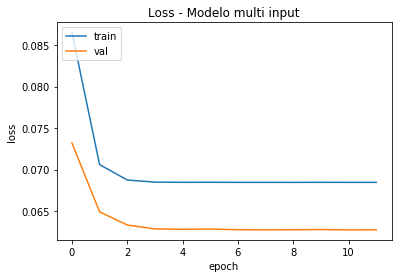

El promedio de y en el conjunto de entrenamiento es 0.1181, y contiene 2886 casos
El promedio de y en el conjunto de validación es 0.129, y contiene 722 casos
El error absoluto promedio del modelo que solo usa imágenes es 0.0635
A su vez, el error absoluto promedio en el modelo multi-input es 0.0627.
Iteración 33 finalizada


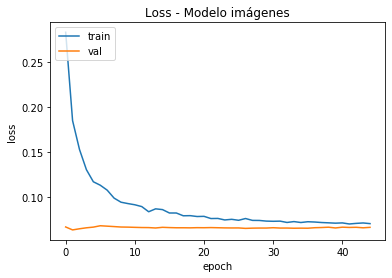

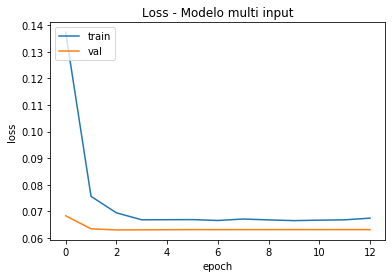

El promedio de y en el conjunto de entrenamiento es 0.1285, y contiene 2886 casos
El promedio de y en el conjunto de validación es 0.1221, y contiene 722 casos
El error absoluto promedio del modelo que solo usa imágenes es 0.066
A su vez, el error absoluto promedio en el modelo multi-input es 0.0631.
Iteración 34 finalizada


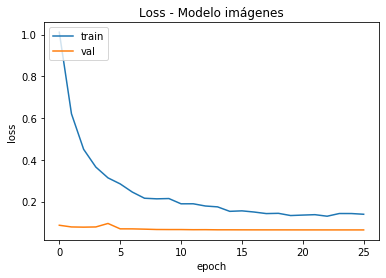

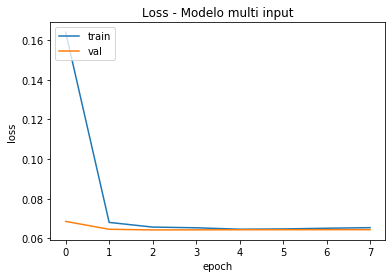

El promedio de y en el conjunto de entrenamiento es 0.1279, y contiene 2886 casos
El promedio de y en el conjunto de validación es 0.1226, y contiene 722 casos
El error absoluto promedio del modelo que solo usa imágenes es 0.0644
A su vez, el error absoluto promedio en el modelo multi-input es 0.0644.
Iteración 35 finalizada


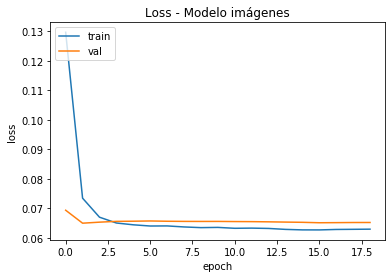

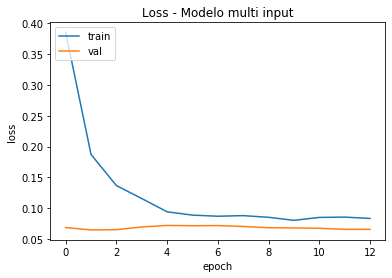

El promedio de y en el conjunto de entrenamiento es 0.1268, y contiene 2886 casos
El promedio de y en el conjunto de validación es 0.1232, y contiene 722 casos
El error absoluto promedio del modelo que solo usa imágenes es 0.0652
A su vez, el error absoluto promedio en el modelo multi-input es 0.0657.
Iteración 36 finalizada


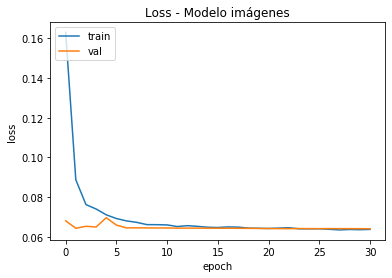

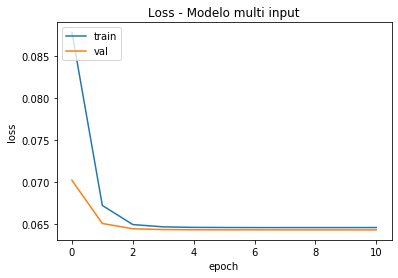

El promedio de y en el conjunto de entrenamiento es 0.1258, y contiene 2886 casos
El promedio de y en el conjunto de validación es 0.1239, y contiene 722 casos
El error absoluto promedio del modelo que solo usa imágenes es 0.0641
A su vez, el error absoluto promedio en el modelo multi-input es 0.0643.
Iteración 37 finalizada


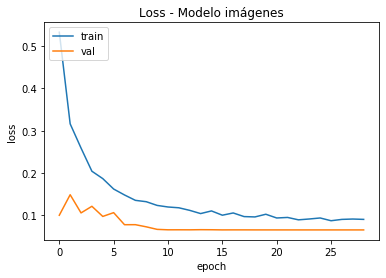

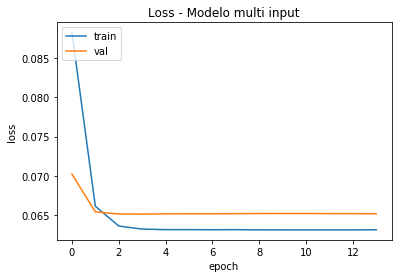

El promedio de y en el conjunto de entrenamiento es 0.1238, y contiene 2886 casos
El promedio de y en el conjunto de validación es 0.1253, y contiene 722 casos
El error absoluto promedio del modelo que solo usa imágenes es 0.0652
A su vez, el error absoluto promedio en el modelo multi-input es 0.0652.
Iteración 38 finalizada


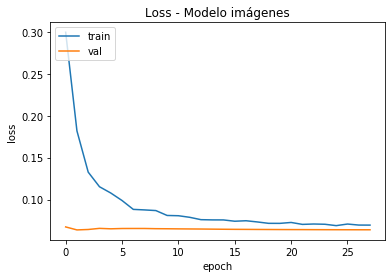

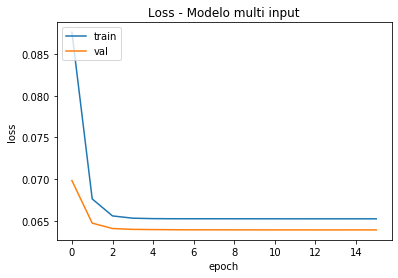

El promedio de y en el conjunto de entrenamiento es 0.1257, y contiene 2886 casos
El promedio de y en el conjunto de validación es 0.124, y contiene 722 casos
El error absoluto promedio del modelo que solo usa imágenes es 0.0641
A su vez, el error absoluto promedio en el modelo multi-input es 0.0639.
Iteración 39 finalizada


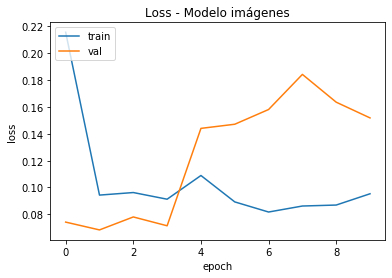

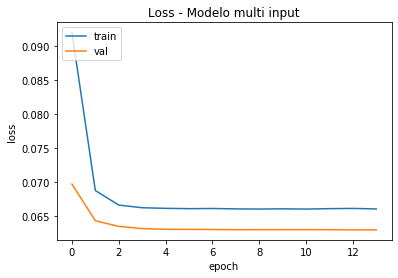

El promedio de y en el conjunto de entrenamiento es 0.1241, y contiene 2886 casos
El promedio de y en el conjunto de validación es 0.1251, y contiene 722 casos
El error absoluto promedio del modelo que solo usa imágenes es 0.1519
A su vez, el error absoluto promedio en el modelo multi-input es 0.0629.
Iteración 40 finalizada


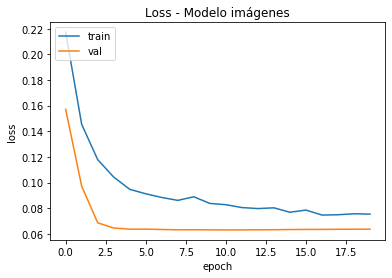

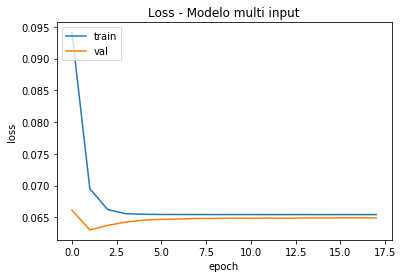

El promedio de y en el conjunto de entrenamiento es 0.1337, y contiene 2886 casos
El promedio de y en el conjunto de validación es 0.1187, y contiene 722 casos
El error absoluto promedio del modelo que solo usa imágenes es 0.0636
A su vez, el error absoluto promedio en el modelo multi-input es 0.0649.
Iteración 41 finalizada


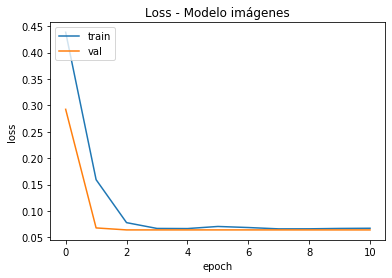

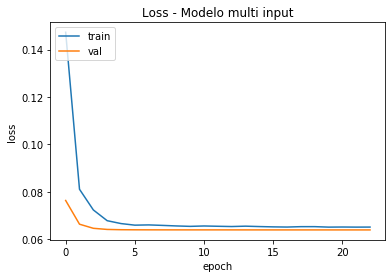

El promedio de y en el conjunto de entrenamiento es 0.123, y contiene 2886 casos
El promedio de y en el conjunto de validación es 0.1258, y contiene 722 casos
El error absoluto promedio del modelo que solo usa imágenes es 0.064
A su vez, el error absoluto promedio en el modelo multi-input es 0.064.
Iteración 42 finalizada


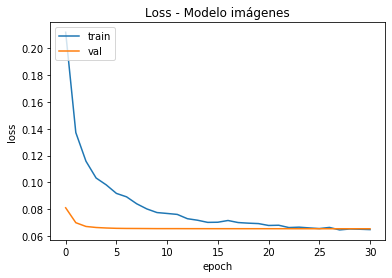

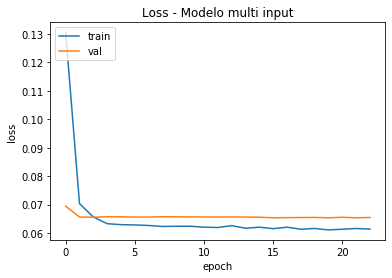

El promedio de y en el conjunto de entrenamiento es 0.126, y contiene 2886 casos
El promedio de y en el conjunto de validación es 0.1238, y contiene 722 casos
El error absoluto promedio del modelo que solo usa imágenes es 0.0655
A su vez, el error absoluto promedio en el modelo multi-input es 0.0655.
Iteración 43 finalizada


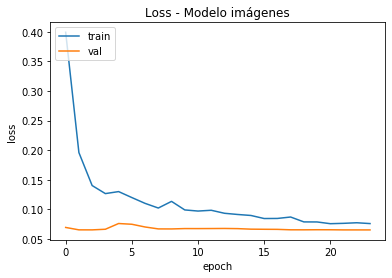

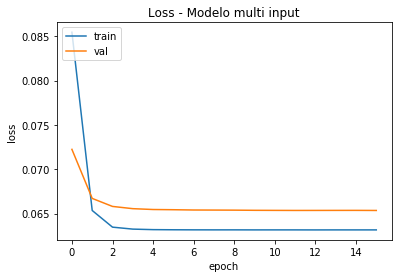

El promedio de y en el conjunto de entrenamiento es 0.1222, y contiene 2886 casos
El promedio de y en el conjunto de validación es 0.1264, y contiene 722 casos
El error absoluto promedio del modelo que solo usa imágenes es 0.0652
A su vez, el error absoluto promedio en el modelo multi-input es 0.0654.
Iteración 44 finalizada


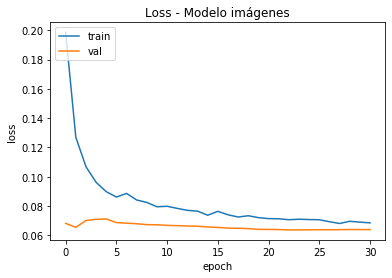

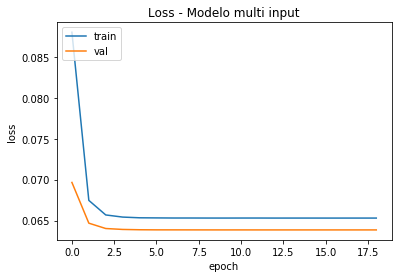

El promedio de y en el conjunto de entrenamiento es 0.1252, y contiene 2886 casos
El promedio de y en el conjunto de validación es 0.1243, y contiene 722 casos
El error absoluto promedio del modelo que solo usa imágenes es 0.0639
A su vez, el error absoluto promedio en el modelo multi-input es 0.0638.
Iteración 45 finalizada


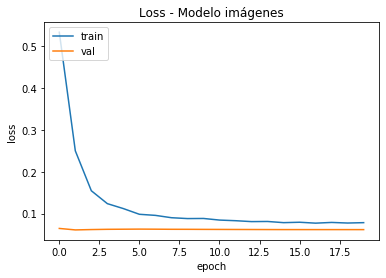

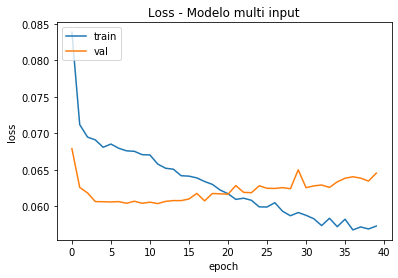

El promedio de y en el conjunto de entrenamiento es 0.1297, y contiene 2886 casos
El promedio de y en el conjunto de validación es 0.1213, y contiene 722 casos
El error absoluto promedio del modelo que solo usa imágenes es 0.0617
A su vez, el error absoluto promedio en el modelo multi-input es 0.0645.
Iteración 46 finalizada


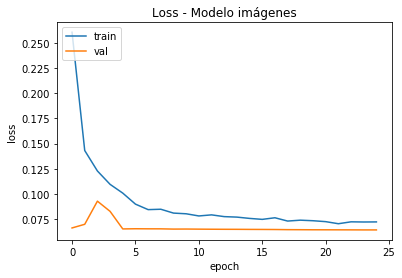

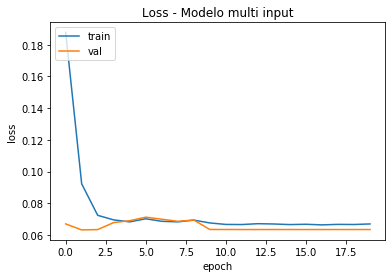

El promedio de y en el conjunto de entrenamiento es 0.1296, y contiene 2886 casos
El promedio de y en el conjunto de validación es 0.1214, y contiene 722 casos
El error absoluto promedio del modelo que solo usa imágenes es 0.0642
A su vez, el error absoluto promedio en el modelo multi-input es 0.0634.
Iteración 47 finalizada


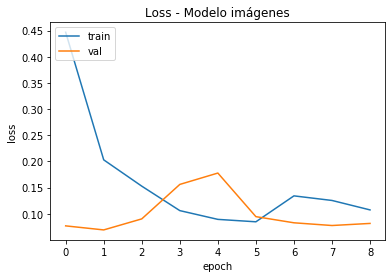

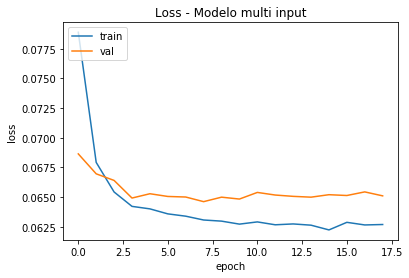

El promedio de y en el conjunto de entrenamiento es 0.1287, y contiene 2886 casos
El promedio de y en el conjunto de validación es 0.122, y contiene 722 casos
El error absoluto promedio del modelo que solo usa imágenes es 0.0814
A su vez, el error absoluto promedio en el modelo multi-input es 0.0651.
Iteración 48 finalizada


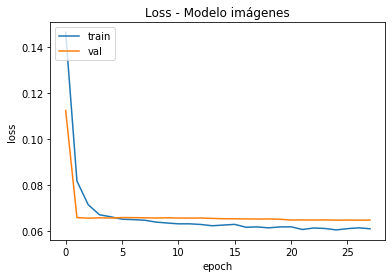

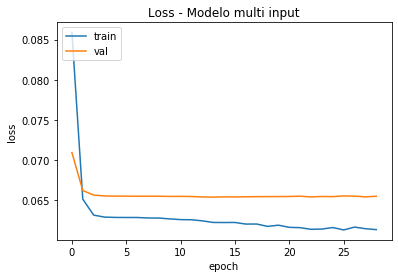

El promedio de y en el conjunto de entrenamiento es 0.1229, y contiene 2886 casos
El promedio de y en el conjunto de validación es 0.1258, y contiene 722 casos
El error absoluto promedio del modelo que solo usa imágenes es 0.0648
A su vez, el error absoluto promedio en el modelo multi-input es 0.0655.
Iteración 49 finalizada


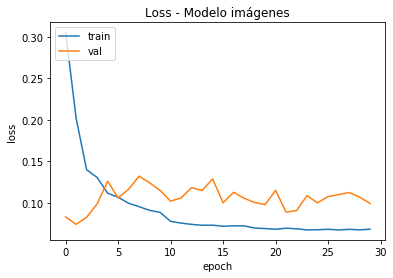

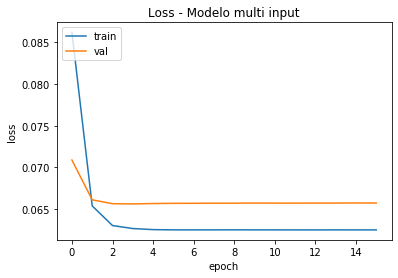

El promedio de y en el conjunto de entrenamiento es 0.1248, y contiene 2886 casos
El promedio de y en el conjunto de validación es 0.1246, y contiene 722 casos
El error absoluto promedio del modelo que solo usa imágenes es 0.0991
A su vez, el error absoluto promedio en el modelo multi-input es 0.0658.
Iteración 50 finalizada


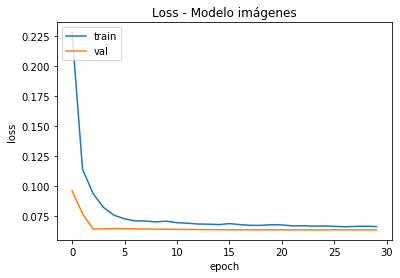

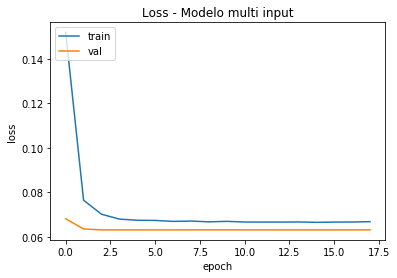

El promedio de y en el conjunto de entrenamiento es 0.1245, y contiene 2886 casos
El promedio de y en el conjunto de validación es 0.1248, y contiene 722 casos
El error absoluto promedio del modelo que solo usa imágenes es 0.0633
A su vez, el error absoluto promedio en el modelo multi-input es 0.0631.
Iteración 51 finalizada


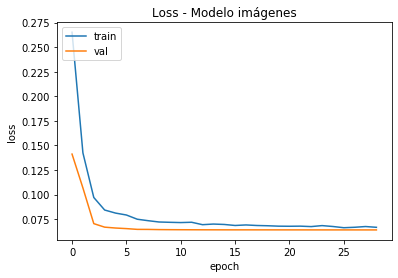

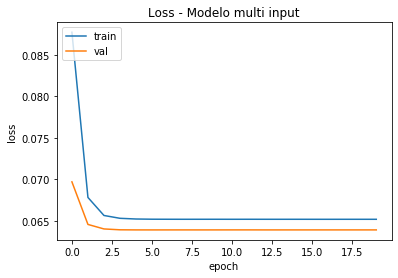

El promedio de y en el conjunto de entrenamiento es 0.1249, y contiene 2886 casos
El promedio de y en el conjunto de validación es 0.1245, y contiene 722 casos
El error absoluto promedio del modelo que solo usa imágenes es 0.064
A su vez, el error absoluto promedio en el modelo multi-input es 0.0639.
Iteración 52 finalizada


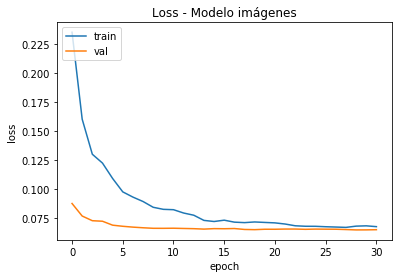

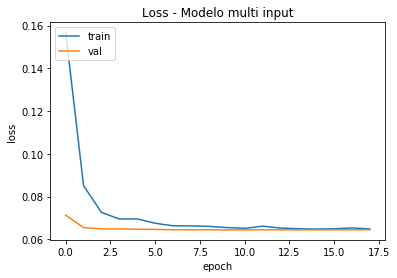

El promedio de y en el conjunto de entrenamiento es 0.124, y contiene 2886 casos
El promedio de y en el conjunto de validación es 0.1251, y contiene 722 casos
El error absoluto promedio del modelo que solo usa imágenes es 0.0653
A su vez, el error absoluto promedio en el modelo multi-input es 0.0645.
Iteración 53 finalizada


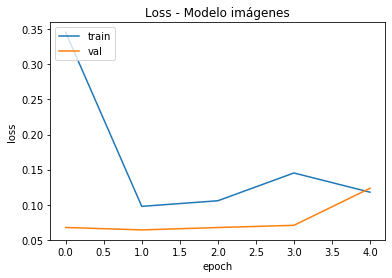

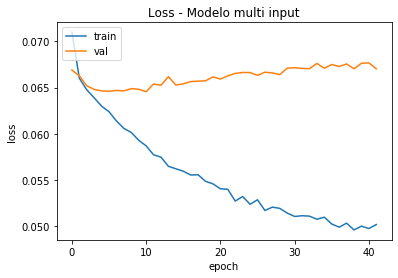

El promedio de y en el conjunto de entrenamiento es 0.1273, y contiene 2886 casos
El promedio de y en el conjunto de validación es 0.123, y contiene 722 casos
El error absoluto promedio del modelo que solo usa imágenes es 0.1234
A su vez, el error absoluto promedio en el modelo multi-input es 0.067.
Iteración 54 finalizada


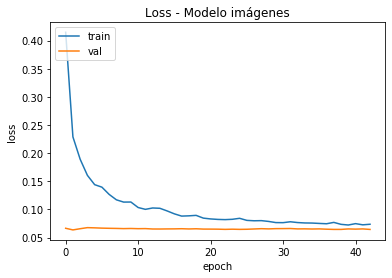

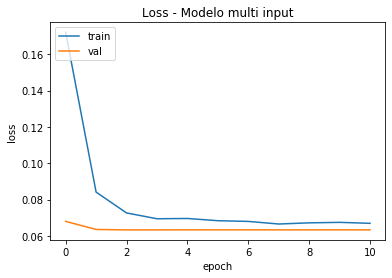

El promedio de y en el conjunto de entrenamiento es 0.1268, y contiene 2886 casos
El promedio de y en el conjunto de validación es 0.1232, y contiene 722 casos
El error absoluto promedio del modelo que solo usa imágenes es 0.0644
A su vez, el error absoluto promedio en el modelo multi-input es 0.0634.
Iteración 55 finalizada


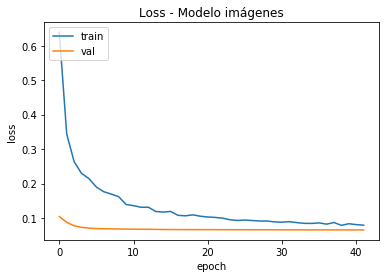

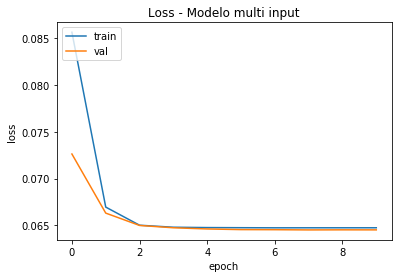

El promedio de y en el conjunto de entrenamiento es 0.1211, y contiene 2886 casos
El promedio de y en el conjunto de validación es 0.1271, y contiene 722 casos
El error absoluto promedio del modelo que solo usa imágenes es 0.0652
A su vez, el error absoluto promedio en el modelo multi-input es 0.0645.
Iteración 56 finalizada


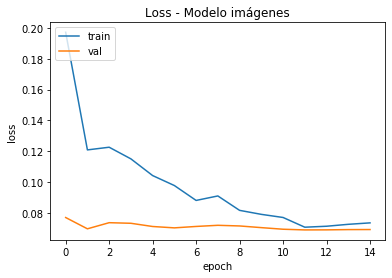

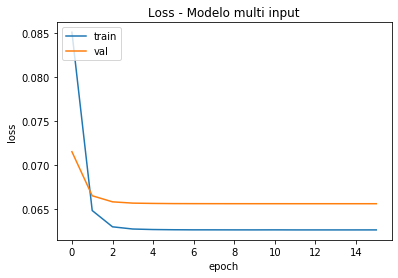

El promedio de y en el conjunto de entrenamiento es 0.1233, y contiene 2886 casos
El promedio de y en el conjunto de validación es 0.1256, y contiene 722 casos
El error absoluto promedio del modelo que solo usa imágenes es 0.0693
A su vez, el error absoluto promedio en el modelo multi-input es 0.0656.
Iteración 57 finalizada


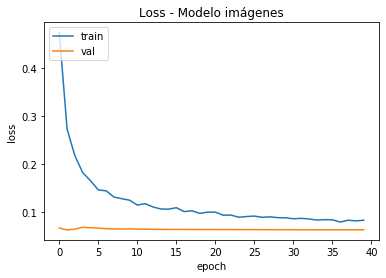

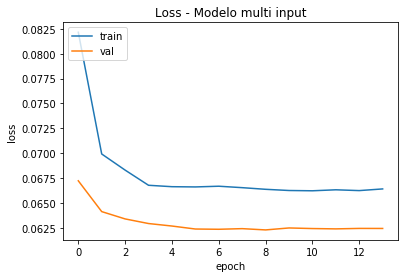

El promedio de y en el conjunto de entrenamiento es 0.1256, y contiene 2886 casos
El promedio de y en el conjunto de validación es 0.124, y contiene 722 casos
El error absoluto promedio del modelo que solo usa imágenes es 0.0631
A su vez, el error absoluto promedio en el modelo multi-input es 0.0624.
Iteración 58 finalizada


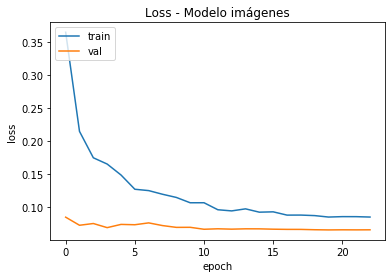

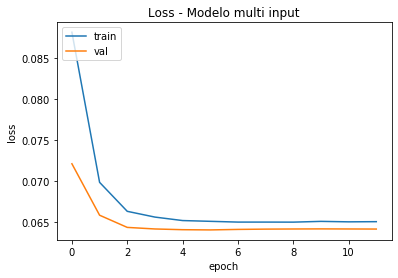

El promedio de y en el conjunto de entrenamiento es 0.1281, y contiene 2886 casos
El promedio de y en el conjunto de validación es 0.1224, y contiene 722 casos
El error absoluto promedio del modelo que solo usa imágenes es 0.0654
A su vez, el error absoluto promedio en el modelo multi-input es 0.0641.
Iteración 59 finalizada


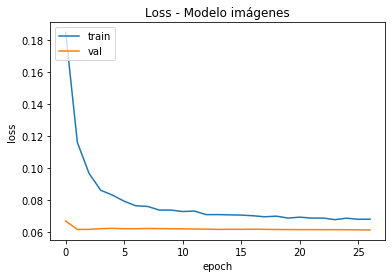

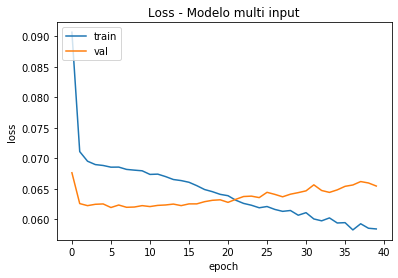

El promedio de y en el conjunto de entrenamiento es 0.1247, y contiene 2886 casos
El promedio de y en el conjunto de validación es 0.1247, y contiene 722 casos
El error absoluto promedio del modelo que solo usa imágenes es 0.0612
A su vez, el error absoluto promedio en el modelo multi-input es 0.0654.
Iteración 60 finalizada


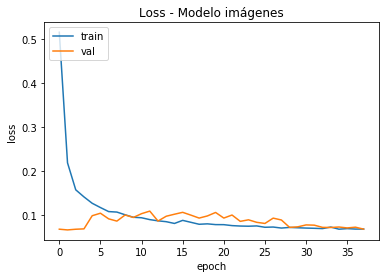

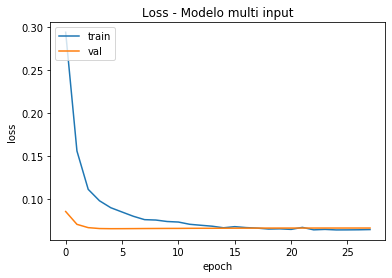

El promedio de y en el conjunto de entrenamiento es 0.1289, y contiene 2886 casos
El promedio de y en el conjunto de validación es 0.1219, y contiene 722 casos
El error absoluto promedio del modelo que solo usa imágenes es 0.068
A su vez, el error absoluto promedio en el modelo multi-input es 0.0666.
Iteración 61 finalizada


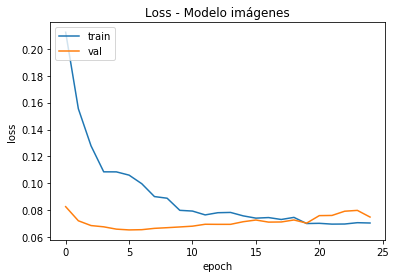

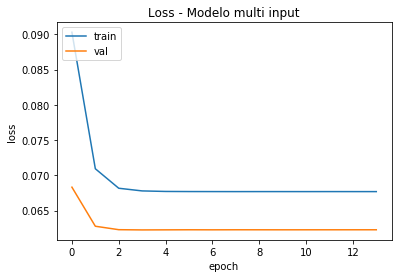

El promedio de y en el conjunto de entrenamiento es 0.1273, y contiene 2886 casos
El promedio de y en el conjunto de validación es 0.1229, y contiene 722 casos
El error absoluto promedio del modelo que solo usa imágenes es 0.0749
A su vez, el error absoluto promedio en el modelo multi-input es 0.0623.
Iteración 62 finalizada


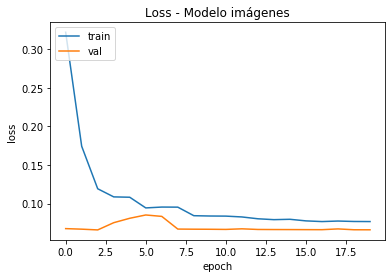

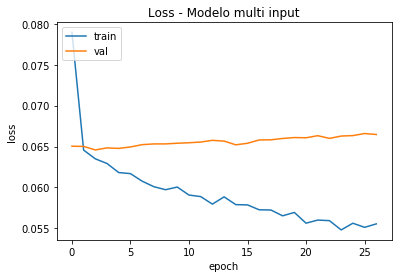

El promedio de y en el conjunto de entrenamiento es 0.1281, y contiene 2886 casos
El promedio de y en el conjunto de validación es 0.1224, y contiene 722 casos
El error absoluto promedio del modelo que solo usa imágenes es 0.066
A su vez, el error absoluto promedio en el modelo multi-input es 0.0665.
Iteración 63 finalizada


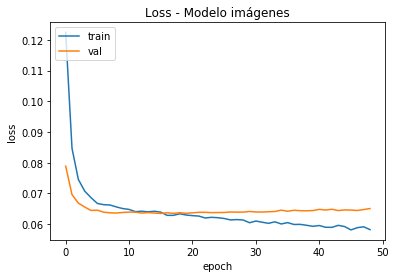

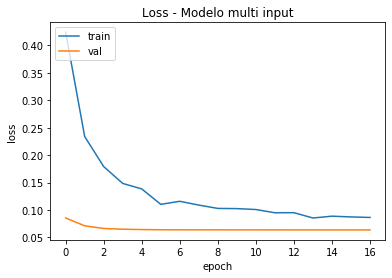

El promedio de y en el conjunto de entrenamiento es 0.1258, y contiene 2886 casos
El promedio de y en el conjunto de validación es 0.124, y contiene 722 casos
El error absoluto promedio del modelo que solo usa imágenes es 0.0651
A su vez, el error absoluto promedio en el modelo multi-input es 0.0636.
Iteración 64 finalizada


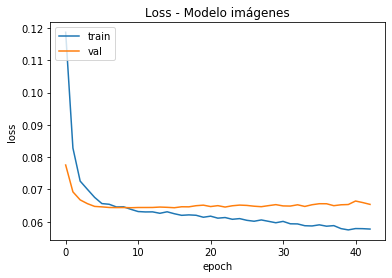

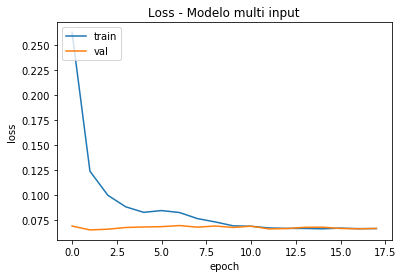

El promedio de y en el conjunto de entrenamiento es 0.126, y contiene 2886 casos
El promedio de y en el conjunto de validación es 0.1238, y contiene 722 casos
El error absoluto promedio del modelo que solo usa imágenes es 0.0654
A su vez, el error absoluto promedio en el modelo multi-input es 0.0662.
Iteración 65 finalizada


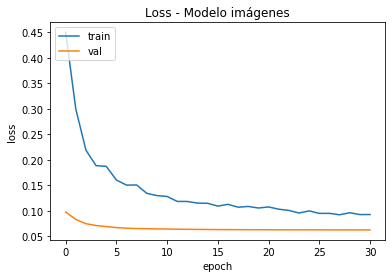

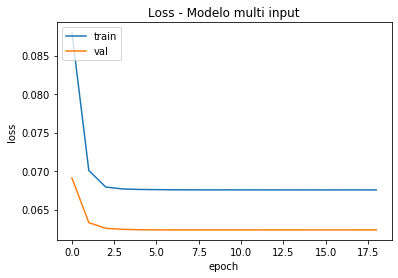

El promedio de y en el conjunto de entrenamiento es 0.1236, y contiene 2886 casos
El promedio de y en el conjunto de validación es 0.1254, y contiene 722 casos
El error absoluto promedio del modelo que solo usa imágenes es 0.0628
A su vez, el error absoluto promedio en el modelo multi-input es 0.0624.
Iteración 66 finalizada


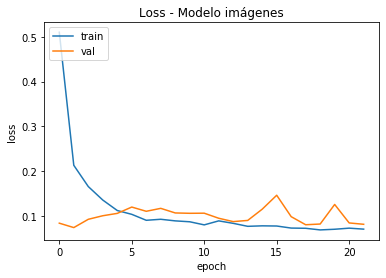

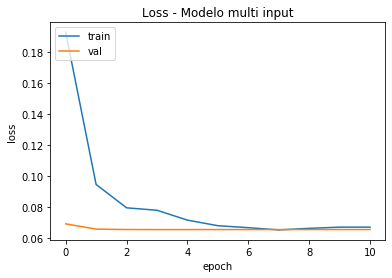

El promedio de y en el conjunto de entrenamiento es 0.1256, y contiene 2886 casos
El promedio de y en el conjunto de validación es 0.124, y contiene 722 casos
El error absoluto promedio del modelo que solo usa imágenes es 0.0815
A su vez, el error absoluto promedio en el modelo multi-input es 0.0656.
Iteración 67 finalizada


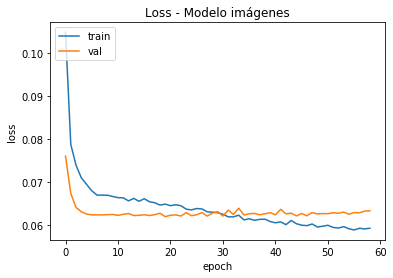

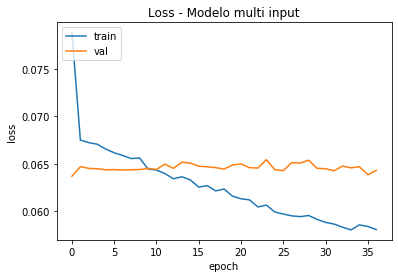

El promedio de y en el conjunto de entrenamiento es 0.1276, y contiene 2886 casos
El promedio de y en el conjunto de validación es 0.1227, y contiene 722 casos
El error absoluto promedio del modelo que solo usa imágenes es 0.0633
A su vez, el error absoluto promedio en el modelo multi-input es 0.0643.
Iteración 68 finalizada


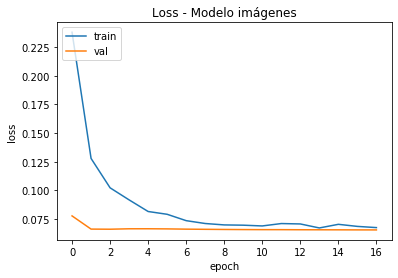

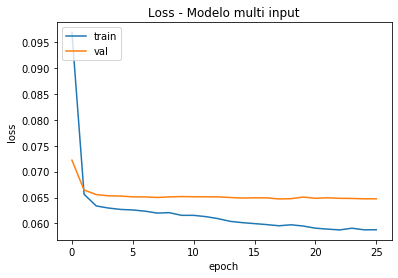

El promedio de y en el conjunto de entrenamiento es 0.1234, y contiene 2886 casos
El promedio de y en el conjunto de validación es 0.1256, y contiene 722 casos
El error absoluto promedio del modelo que solo usa imágenes es 0.0655
A su vez, el error absoluto promedio en el modelo multi-input es 0.0648.
Iteración 69 finalizada


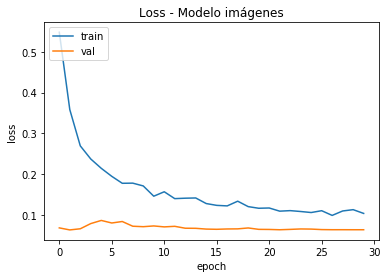

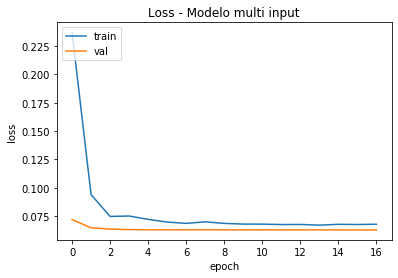

El promedio de y en el conjunto de entrenamiento es 0.1237, y contiene 2886 casos
El promedio de y en el conjunto de validación es 0.1253, y contiene 722 casos
El error absoluto promedio del modelo que solo usa imágenes es 0.0631
A su vez, el error absoluto promedio en el modelo multi-input es 0.0629.
Iteración 70 finalizada


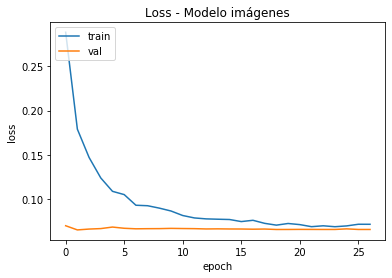

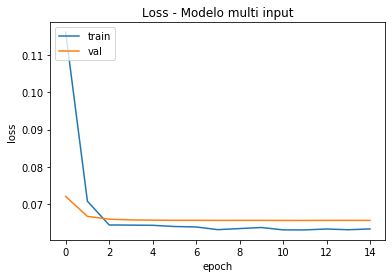

El promedio de y en el conjunto de entrenamiento es 0.1205, y contiene 2886 casos
El promedio de y en el conjunto de validación es 0.1274, y contiene 722 casos
El error absoluto promedio del modelo que solo usa imágenes es 0.066
A su vez, el error absoluto promedio en el modelo multi-input es 0.0657.
Iteración 71 finalizada


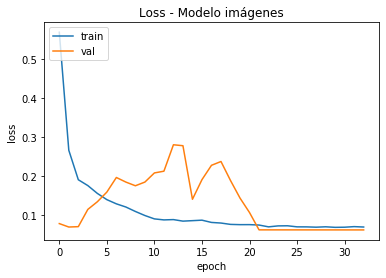

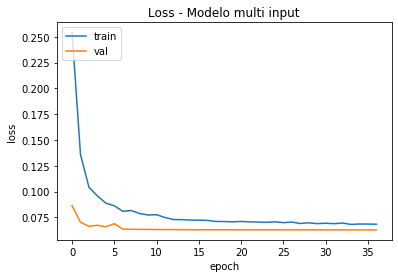

El promedio de y en el conjunto de entrenamiento es 0.1276, y contiene 2886 casos
El promedio de y en el conjunto de validación es 0.1227, y contiene 722 casos
El error absoluto promedio del modelo que solo usa imágenes es 0.0628
A su vez, el error absoluto promedio en el modelo multi-input es 0.0628.
Iteración 72 finalizada


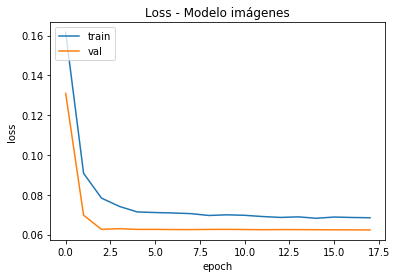

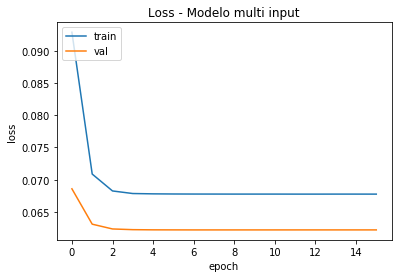

El promedio de y en el conjunto de entrenamiento es 0.1287, y contiene 2886 casos
El promedio de y en el conjunto de validación es 0.122, y contiene 722 casos
El error absoluto promedio del modelo que solo usa imágenes es 0.0624
A su vez, el error absoluto promedio en el modelo multi-input es 0.0622.
Iteración 73 finalizada


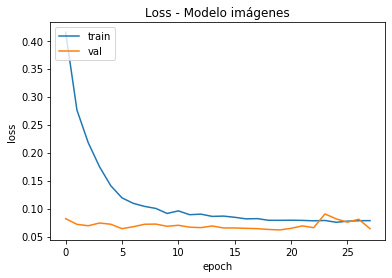

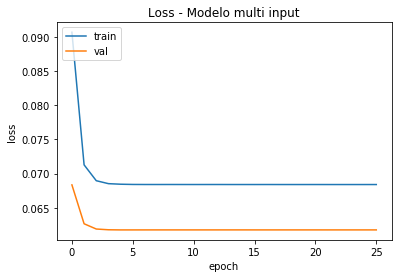

El promedio de y en el conjunto de entrenamiento es 0.1266, y contiene 2886 casos
El promedio de y en el conjunto de validación es 0.1234, y contiene 722 casos
El error absoluto promedio del modelo que solo usa imágenes es 0.064
A su vez, el error absoluto promedio en el modelo multi-input es 0.0618.
Iteración 74 finalizada


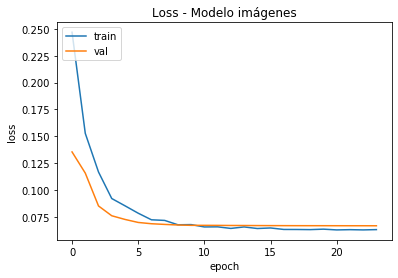

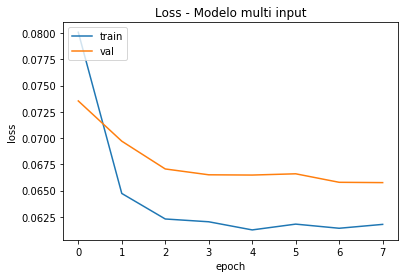

El promedio de y en el conjunto de entrenamiento es 0.1226, y contiene 2886 casos
El promedio de y en el conjunto de validación es 0.126, y contiene 722 casos
El error absoluto promedio del modelo que solo usa imágenes es 0.0668
A su vez, el error absoluto promedio en el modelo multi-input es 0.0658.
Iteración 75 finalizada


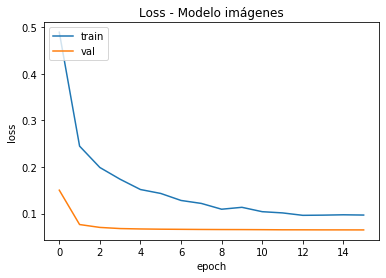

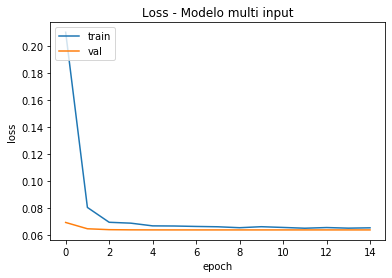

El promedio de y en el conjunto de entrenamiento es 0.1257, y contiene 2886 casos
El promedio de y en el conjunto de validación es 0.124, y contiene 722 casos
El error absoluto promedio del modelo que solo usa imágenes es 0.0648
A su vez, el error absoluto promedio en el modelo multi-input es 0.064.
Iteración 76 finalizada


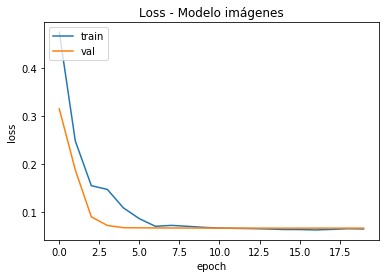

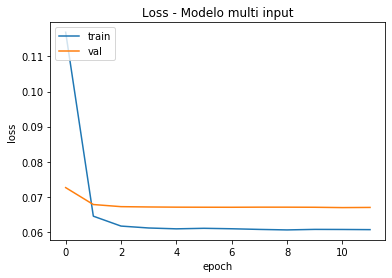

El promedio de y en el conjunto de entrenamiento es 0.1236, y contiene 2886 casos
El promedio de y en el conjunto de validación es 0.1254, y contiene 722 casos
El error absoluto promedio del modelo que solo usa imágenes es 0.067
A su vez, el error absoluto promedio en el modelo multi-input es 0.067.
Iteración 77 finalizada


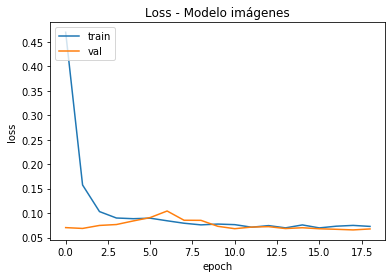

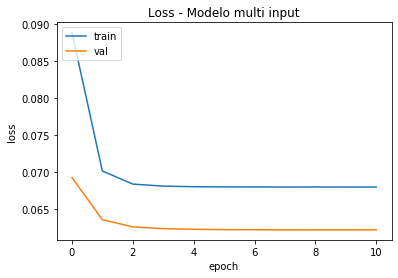

El promedio de y en el conjunto de entrenamiento es 0.1255, y contiene 2886 casos
El promedio de y en el conjunto de validación es 0.1242, y contiene 722 casos
El error absoluto promedio del modelo que solo usa imágenes es 0.0676
A su vez, el error absoluto promedio en el modelo multi-input es 0.0621.
Iteración 78 finalizada


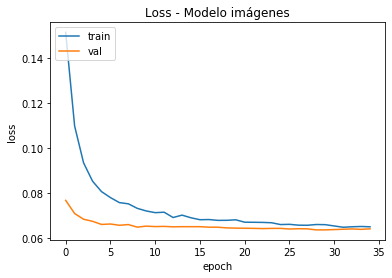

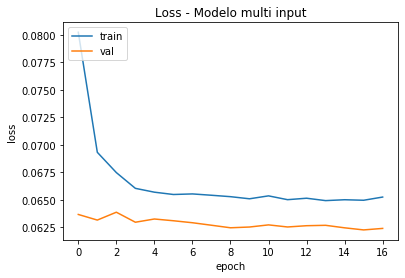

El promedio de y en el conjunto de entrenamiento es 0.1246, y contiene 2886 casos
El promedio de y en el conjunto de validación es 0.1247, y contiene 722 casos
El error absoluto promedio del modelo que solo usa imágenes es 0.0641
A su vez, el error absoluto promedio en el modelo multi-input es 0.0624.
Iteración 79 finalizada


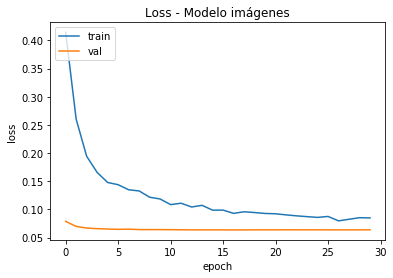

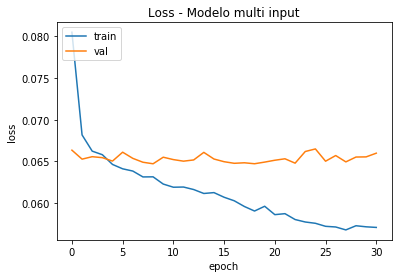

El promedio de y en el conjunto de entrenamiento es 0.13, y contiene 2886 casos
El promedio de y en el conjunto de validación es 0.1211, y contiene 722 casos
El error absoluto promedio del modelo que solo usa imágenes es 0.0639
A su vez, el error absoluto promedio en el modelo multi-input es 0.066.
Iteración 80 finalizada


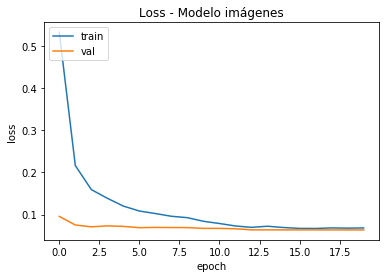

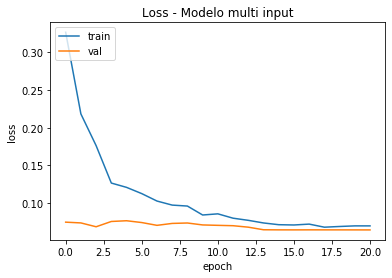

El promedio de y en el conjunto de entrenamiento es 0.1236, y contiene 2886 casos
El promedio de y en el conjunto de validación es 0.1254, y contiene 722 casos
El error absoluto promedio del modelo que solo usa imágenes es 0.0638
A su vez, el error absoluto promedio en el modelo multi-input es 0.0644.
Iteración 81 finalizada


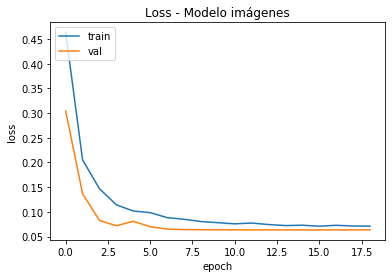

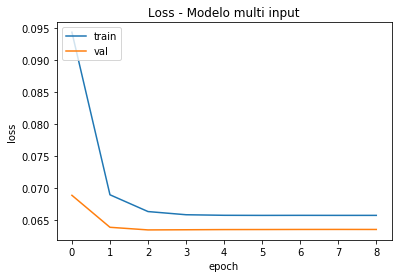

El promedio de y en el conjunto de entrenamiento es 0.1266, y contiene 2886 casos
El promedio de y en el conjunto de validación es 0.1234, y contiene 722 casos
El error absoluto promedio del modelo que solo usa imágenes es 0.0635
A su vez, el error absoluto promedio en el modelo multi-input es 0.0636.
Iteración 82 finalizada


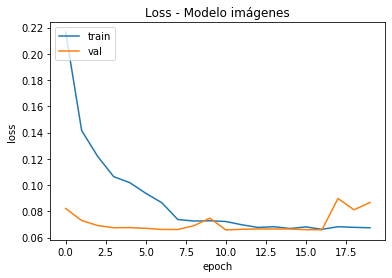

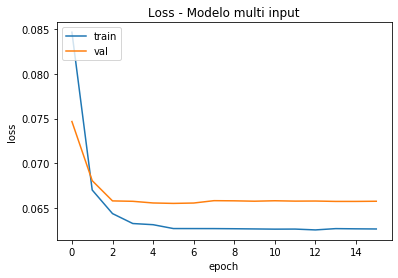

El promedio de y en el conjunto de entrenamiento es 0.1273, y contiene 2886 casos
El promedio de y en el conjunto de validación es 0.1229, y contiene 722 casos
El error absoluto promedio del modelo que solo usa imágenes es 0.0868
A su vez, el error absoluto promedio en el modelo multi-input es 0.0657.
Iteración 83 finalizada


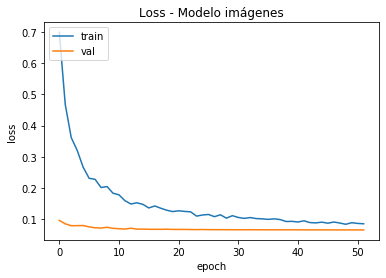

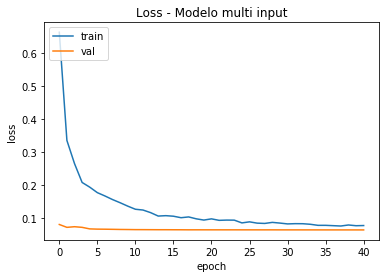

El promedio de y en el conjunto de entrenamiento es 0.1219, y contiene 2886 casos
El promedio de y en el conjunto de validación es 0.1265, y contiene 722 casos
El error absoluto promedio del modelo que solo usa imágenes es 0.0653
A su vez, el error absoluto promedio en el modelo multi-input es 0.065.
Iteración 84 finalizada


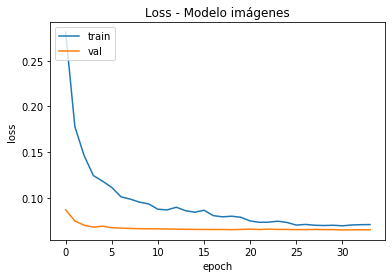

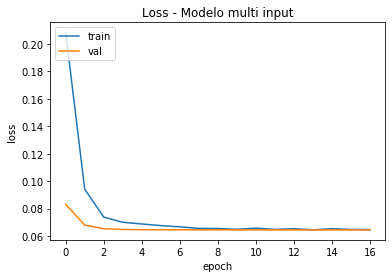

El promedio de y en el conjunto de entrenamiento es 0.1263, y contiene 2886 casos
El promedio de y en el conjunto de validación es 0.1236, y contiene 722 casos
El error absoluto promedio del modelo que solo usa imágenes es 0.065
A su vez, el error absoluto promedio en el modelo multi-input es 0.0645.
Iteración 85 finalizada


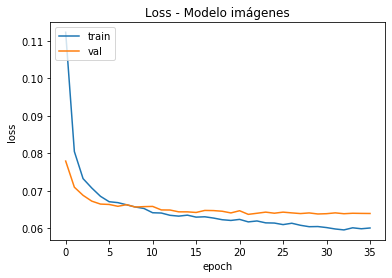

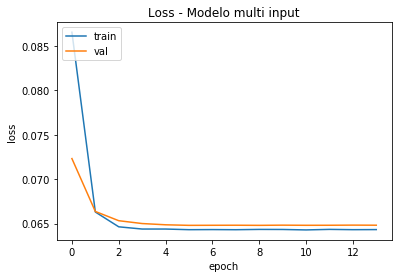

El promedio de y en el conjunto de entrenamiento es 0.1202, y contiene 2886 casos
El promedio de y en el conjunto de validación es 0.1277, y contiene 722 casos
El error absoluto promedio del modelo que solo usa imágenes es 0.064
A su vez, el error absoluto promedio en el modelo multi-input es 0.0648.
Iteración 86 finalizada


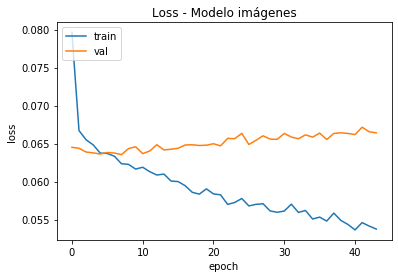

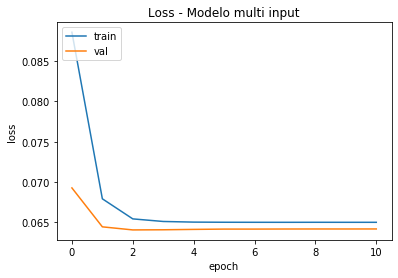

El promedio de y en el conjunto de entrenamiento es 0.1254, y contiene 2886 casos
El promedio de y en el conjunto de validación es 0.1242, y contiene 722 casos
El error absoluto promedio del modelo que solo usa imágenes es 0.0664
A su vez, el error absoluto promedio en el modelo multi-input es 0.0641.
Iteración 87 finalizada


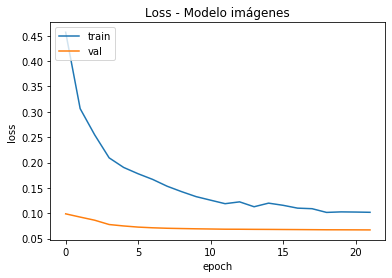

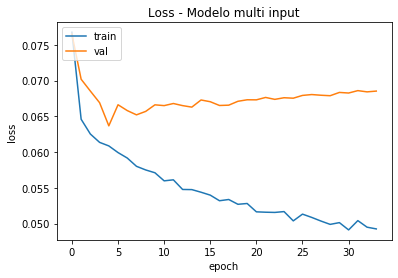

El promedio de y en el conjunto de entrenamiento es 0.1212, y contiene 2886 casos
El promedio de y en el conjunto de validación es 0.127, y contiene 722 casos
El error absoluto promedio del modelo que solo usa imágenes es 0.0671
A su vez, el error absoluto promedio en el modelo multi-input es 0.0685.
Iteración 88 finalizada


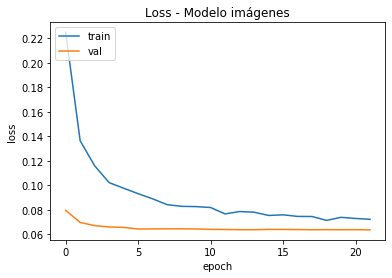

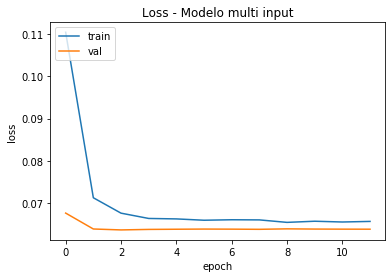

El promedio de y en el conjunto de entrenamiento es 0.1287, y contiene 2886 casos
El promedio de y en el conjunto de validación es 0.122, y contiene 722 casos
El error absoluto promedio del modelo que solo usa imágenes es 0.0636
A su vez, el error absoluto promedio en el modelo multi-input es 0.0638.
Iteración 89 finalizada


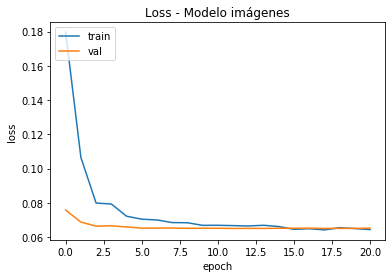

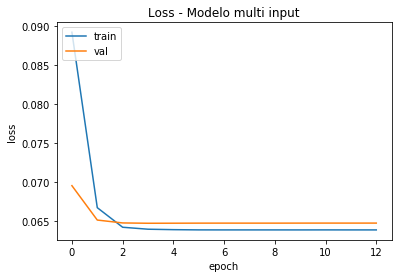

El promedio de y en el conjunto de entrenamiento es 0.1278, y contiene 2886 casos
El promedio de y en el conjunto de validación es 0.1226, y contiene 722 casos
El error absoluto promedio del modelo que solo usa imágenes es 0.0652
A su vez, el error absoluto promedio en el modelo multi-input es 0.0648.
Iteración 90 finalizada


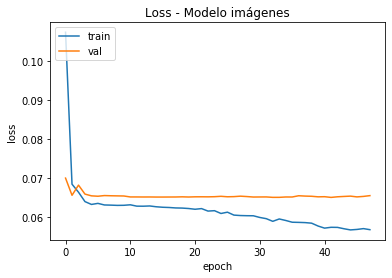

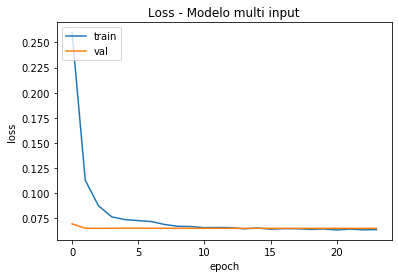

El promedio de y en el conjunto de entrenamiento es 0.1229, y contiene 2886 casos
El promedio de y en el conjunto de validación es 0.1259, y contiene 722 casos
El error absoluto promedio del modelo que solo usa imágenes es 0.0655
A su vez, el error absoluto promedio en el modelo multi-input es 0.0652.
Iteración 91 finalizada


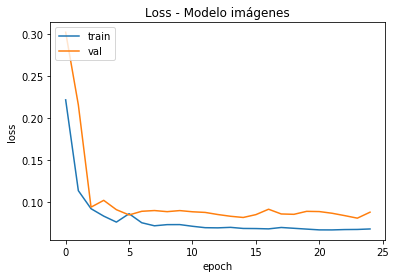

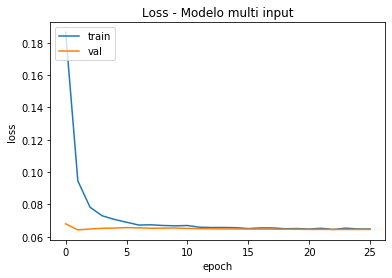

El promedio de y en el conjunto de entrenamiento es 0.1272, y contiene 2886 casos
El promedio de y en el conjunto de validación es 0.123, y contiene 722 casos
El error absoluto promedio del modelo que solo usa imágenes es 0.0874
A su vez, el error absoluto promedio en el modelo multi-input es 0.0645.
Iteración 92 finalizada


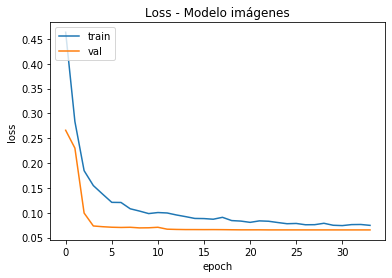

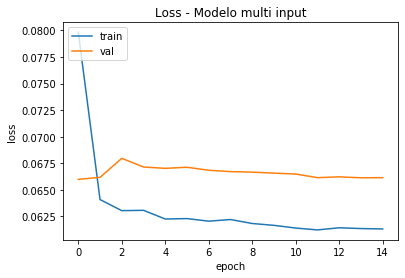

El promedio de y en el conjunto de entrenamiento es 0.1257, y contiene 2886 casos
El promedio de y en el conjunto de validación es 0.124, y contiene 722 casos
El error absoluto promedio del modelo que solo usa imágenes es 0.0655
A su vez, el error absoluto promedio en el modelo multi-input es 0.0661.
Iteración 93 finalizada


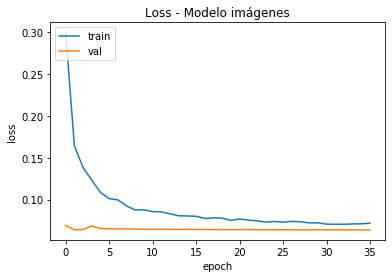

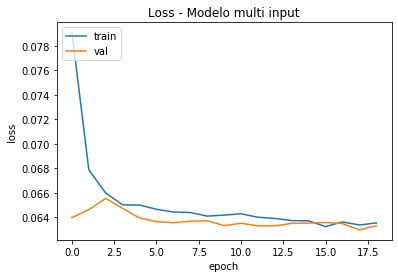

El promedio de y en el conjunto de entrenamiento es 0.1192, y contiene 2886 casos
El promedio de y en el conjunto de validación es 0.1283, y contiene 722 casos
El error absoluto promedio del modelo que solo usa imágenes es 0.0637
A su vez, el error absoluto promedio en el modelo multi-input es 0.0633.
Iteración 94 finalizada


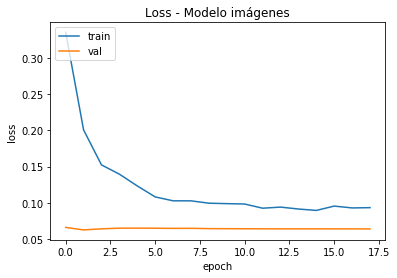

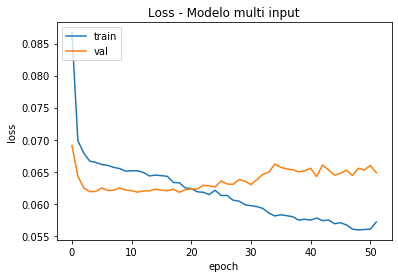

El promedio de y en el conjunto de entrenamiento es 0.1268, y contiene 2886 casos
El promedio de y en el conjunto de validación es 0.1233, y contiene 722 casos
El error absoluto promedio del modelo que solo usa imágenes es 0.064
A su vez, el error absoluto promedio en el modelo multi-input es 0.0648.
Iteración 95 finalizada


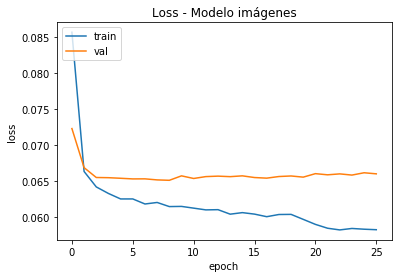

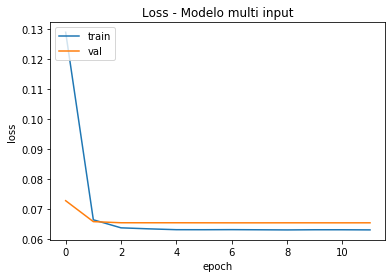

El promedio de y en el conjunto de entrenamiento es 0.1259, y contiene 2886 casos
El promedio de y en el conjunto de validación es 0.1239, y contiene 722 casos
El error absoluto promedio del modelo que solo usa imágenes es 0.066
A su vez, el error absoluto promedio en el modelo multi-input es 0.0654.
Iteración 96 finalizada


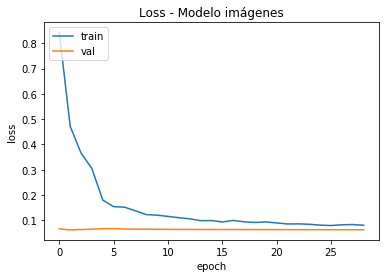

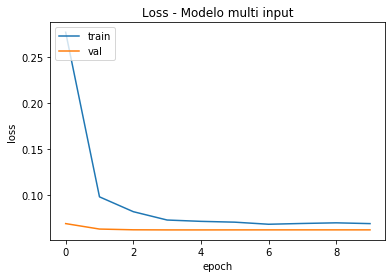

El promedio de y en el conjunto de entrenamiento es 0.1245, y contiene 2886 casos
El promedio de y en el conjunto de validación es 0.1248, y contiene 722 casos
El error absoluto promedio del modelo que solo usa imágenes es 0.0631
A su vez, el error absoluto promedio en el modelo multi-input es 0.0624.
Iteración 97 finalizada


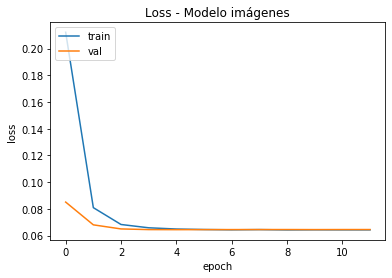

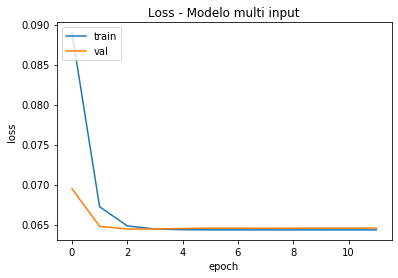

El promedio de y en el conjunto de entrenamiento es 0.1268, y contiene 2886 casos
El promedio de y en el conjunto de validación es 0.1233, y contiene 722 casos
El error absoluto promedio del modelo que solo usa imágenes es 0.0645
A su vez, el error absoluto promedio en el modelo multi-input es 0.0646.
Iteración 98 finalizada


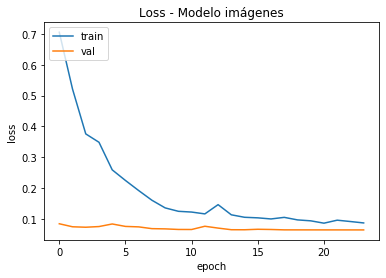

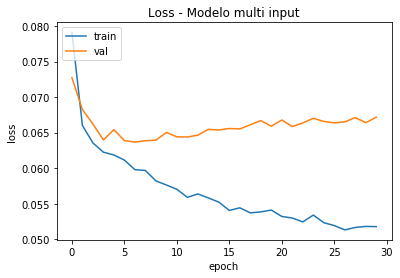

El promedio de y en el conjunto de entrenamiento es 0.1231, y contiene 2886 casos
El promedio de y en el conjunto de validación es 0.1257, y contiene 722 casos
El error absoluto promedio del modelo que solo usa imágenes es 0.0642
A su vez, el error absoluto promedio en el modelo multi-input es 0.0672.
Iteración 99 finalizada


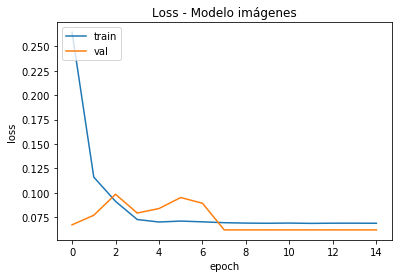

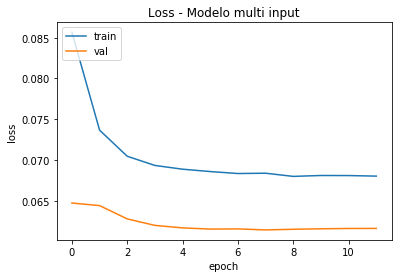

El promedio de y en el conjunto de entrenamiento es 0.1279, y contiene 2886 casos
El promedio de y en el conjunto de validación es 0.1225, y contiene 722 casos
El error absoluto promedio del modelo que solo usa imágenes es 0.0619
A su vez, el error absoluto promedio en el modelo multi-input es 0.0616.
Iteración 100 finalizada


In [10]:
resultados_modelo_solo_imagenes = []
resultados_modelo_multi_input = []

for i in range(100): #Voy a correr 100 veces el experimento
    
    
    X_train_feat,X_train_im, X_val_feat,X_val_im,y_train,y_val = preprocesa_atributos('train_original2.csv')
    
    
    Union_train = pd.concat([X_train_im, X_train_feat,y_train],axis=1)

    x1=Union_train.copy()
    x1['Image_path']=x1['Image_path'].str.replace('.jpg','_1.jpg')

    x2=Union_train.copy()
    x2['Image_path']=x2['Image_path'].str.replace('.jpg','_2.jpg')

    x3=Union_train.copy()
    x3['Image_path']=x3['Image_path'].str.replace('.jpg','_3.jpg')

    x4=Union_train.copy()
    x4['Image_path']=x4['Image_path'].str.replace('.jpg','_4.jpg')

    x5=Union_train.copy()
    x5['Image_path']=x5['Image_path'].str.replace('.jpg','_5.jpg')

    Union_X_train = pd.concat([Union_train,x1,x2,x3,x4,x5], axis=0)

    X_train_im = Union_X_train['Image_path']
    X_train_feat = Union_X_train[['relative_max_cov','Cost_of_vehicle','dias_pendientes_cobertura','A',
                                  'AA','AC','B','BB','BC','BQ','C','DA','O','RE']]
    y_train = Union_X_train['relative_amount']
    
    
    
    imagenes_train = carga_imagenes(X_train_im,'Fotos_train_aum')
    imagenes_val = carga_imagenes(X_val_im,'Fotos_train_aum')
    
    
    
    
    cnn1 = create_cnn(64, 64, 3)
    cnn2 = create_cnn(64, 64, 3)
    mlp = create_mlp(X_train_feat.shape[1])

    opt = Adam(learning_rate=1e-3,decay = 1e-2) # Hiperparametros
    callback = EarlyStopping(monitor='loss', patience=3) # No quiero gastar recursos innecesarios, con callback

    cnn1.compile(loss="mae", 
                  optimizer=opt)

    #print("[INFO] Entrenando modelo con imágenes...")
    history_imagenes = cnn1.fit(
        x=imagenes_train, 
        y=y_train.values,
        validation_data=(imagenes_val, y_val.values),
        epochs=500, 
        batch_size=16,
        verbose=0,
        callbacks = [callback])

    # Listar la historia
    #print(history_imagenes.history.keys())
    # Generar gráficos
    plt.plot(history_imagenes.history['loss'])
    plt.plot(history_imagenes.history['val_loss'])
    plt.title('Loss - Modelo imágenes')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    y_pred_img = cnn1.predict(imagenes_val)

    error_promedio_imagenes = mean_absolute_error(y_val.values.flatten(),y_pred_img)
    
    resultados_modelo_solo_imagenes.append(error_promedio_imagenes)

    #Y ahora entreno el modelo que utiliza como insumos datos tabulares y las fotos

    combinedInput = concatenate([mlp.output, cnn2.output])
    x = Dense(1, activation="relu")(combinedInput)
    x = Dense(1, activation="linear")(x)

    model = Model(inputs=[mlp.input, cnn2.input], outputs=x)

    opt = Adam(learning_rate=1e-3,decay = 1e-2) # Hiperparametros
    callback = EarlyStopping(monitor='loss', patience=3) # No quiero gastar recursos innecesarios, con callback

    model.compile(loss="mae", 
                  optimizer=opt)

    # Entrenamos el modelo
    #print("[INFO] Entrenando modelo multi input...")
    history = model.fit(
        x=[X_train_feat.values, imagenes_train], 
        y=y_train.values,
        validation_data=([X_val_feat.values, imagenes_val], y_val.values),
        epochs=100, 
        batch_size=16,
        verbose=0,
        callbacks = [callback])


    # Listar la historia
    #print(history.history.keys())
    # Generar gráficos
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss - Modelo multi input')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
    
    y_pred_mi = model.predict([X_val_feat.values, imagenes_val])

    error_promedio_mi = mean_absolute_error(y_val.values.flatten(),y_pred_mi)
    
    resultados_modelo_multi_input.append(error_promedio_mi)
    
    
    print(f"El promedio de y en el conjunto de entrenamiento es {round(np.mean(y_train),4)}, y contiene {len(y_train)} casos")
    print(f"El promedio de y en el conjunto de validación es {round(np.mean(y_val),4)}, y contiene {len(y_val)} casos")
    

    print(f"El error absoluto promedio del modelo que solo usa imágenes es {round(error_promedio_imagenes,4)}")
    print(f"A su vez, el error absoluto promedio en el modelo multi-input es {round(error_promedio_mi,4)}.")
    print(f"Iteración {i+1} finalizada")
    
    del cnn1
    del cnn2
    del mlp

In [11]:
imagenes_media = np.mean(resultados_modelo_solo_imagenes)
multi_input_media = np.mean(resultados_modelo_multi_input)

print("Promedio error solo imágenes:",imagenes_media)
print("Promedio error multi input:",multi_input_media)


imagenes_std = np.std(resultados_modelo_solo_imagenes)
multi_input_std = np.std(resultados_modelo_multi_input)

print("Desviación Estándar solo imágenes:",imagenes_std )
print("Desviación Estándar solo multi_input:",multi_input_std)

ttest,pval = ttest_ind(resultados_modelo_solo_imagenes,resultados_modelo_multi_input)

print("p-value",pval)
if pval <0.05:
  print("No aceptamos hipótesis nula, las medias debieran ser distintas")
else:
  print("Aceptamos la hipótesis nula, las medias deben ser equivalentes")

Promedio error solo imágenes: 0.06791369481589067
Promedio error multi input: 0.06467908075124995
Desviación Estándar solo imágenes: 0.012078588690170386
Desviación Estándar solo multi_input: 0.0014529543921082474
p-value 0.00881261148238527
No aceptamos hipótesis nula, las medias debieran ser distintas


In [12]:
compara = pd.DataFrame(zip(resultados_modelo_multi_input,resultados_modelo_solo_imagenes),
      columns=['error_solo_imagen','error_multi_input'])

In [13]:
import seaborn as sns

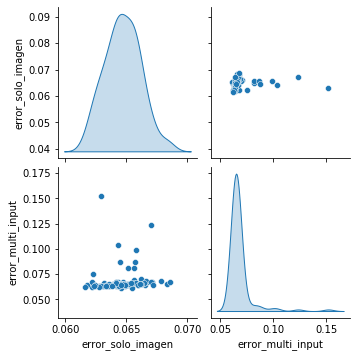

In [14]:
sns.pairplot(compara, diag_kind='kde')

In [15]:
compara.to_csv('resultados.csv',index=False)